Last updated: February 10, 2025

This project was originally done in April 2022 and was originally a group project by the three of us:
- [Iris Lew](https://www.linkedin.com/in/iris-lew/)
- [Rebecca Sun](https://www.linkedin.com/in/rebeccasun3/)
- [Ben Meier](https://www.linkedin.com/in/meierbenjamin/)

We were tasked to do an exploratory data analysis (EDA). While the overall structure and some of the analysis is the same, I've redone the writeup, code, and updated the analysis in October-December 2022. In June 2024, I added in the regression discontinuity design for additional analysis. In February 2025, I added in the analysis for the unincorporated areas only.

This notebook is split into three parts:

1.   EDA
2.   Analysis on the Full Dataset
3.   Analysis on the Unincorporated Areas Only

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iris-lew/projects/blob/main/project_001_LATrafficCollisions/LA_Traffic_Collisions_2_Analysis_FullDataSet.ipynb)


# Setup

I set up the necessary libraries to import the data, do the analysis, and create plots.

In [1]:
### delete when done
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [2]:
!pip install rdrobust

In [3]:
# Import modules
from copy import deepcopy
from matplotlib import ticker

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import folium
from IPython.display import HTML
from folium.plugins import HeatMap

pd.set_option('display.max_columns', None)

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from rdrobust import rdrobust, rdbwselect, rdplot

import geopandas as gpd
from shapely.geometry import Point

In [4]:
dfin = pd.read_pickle('LA_Traffic_Collisions_dfin_1.pkl')
print(dfin.shape)
dfin.head()

(569291, 38)


,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean,cross_street_clean,location_clean,latitude,longitude,victim_sex_clean,victim_descent_clean
0,190319651,08/24/2019,08/24/2019,04:50,3,Southwest,356,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",2019-08-24 04:50:00,2019-08-24,True,0:00:00,0,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",34.0255,-118.3002,Male,Hispanic/Latin/Mexican
1,190319680,08/30/2019,08/30/2019,23:20,3,Southwest,355,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",2019-08-30 23:20:00,2019-08-30,True,0:00:00,0,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",34.0256,-118.3089,Female,Hispanic/Latin/Mexican
2,190413769,08/25/2019,08/25/2019,05:45,4,Hollenbeck,422,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",2019-08-25 05:45:00,2019-08-25,True,0:00:00,0,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",34.0738,-118.2078,Male,Unknown
3,190127578,11/20/2019,11/20/2019,03:50,1,Central,128,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",2019-11-20 03:50:00,2019-11-20,True,0:00:00,0,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014,1ST,CENTRAL,"(34.0492, -118.2391)",34.0492,-118.2391,Male,Hispanic/Latin/Mexican
4,190319695,08/30/2019,08/30/2019,21:00,3,Southwest,374,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",2019-08-30 21:00:00,2019-08-30,True,0:00:00,0,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",34.0108,-118.3182,Male,Black


In [5]:
mo_fin = pd.read_pickle('LA_Traffic_Collisions_mo_fin_1.pkl')
print(mo_fin.shape)
mo_fin.head()

(3160710, 5)


,dr_number,orig_var,mo_code,code_def,mo_code_clean
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes,3036
1,190319680,mo_code_0,3037,T/C - At Intersection - No,3037
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident,0605
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident,0605


As I want to examine the effects of Vision Zero, I created two additional data frames off of these initital data frames: pre-Vision Zero (before Aug 24, 2015) and post-Vision Zero (the day of and after Aug 24, 2015).

In [6]:
dfin_p2015 = dfin[dfin.dttm_occurred.dt.date<datetime.date(2015,8,24)]
dfin_2015p = dfin[dfin.dttm_occurred.dt.date>=datetime.date(2015,8,24)]

# Analysis

## Dates and Time

I decided to look if there are patterns across date and time, including to explore for victim patterns.
* Is there an overall trend?
* Are there patterns by seasons? Holidays? Months? Time of day?
    * Are there patterns by victims?

First, I took a look at the cumulative sum of collisions to see if there are any patterns across the entire dataset. This would allow me to quickly see if there is a pattern by season or month that I can investigate further.

<ipython-input-7-47506958fc1c>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


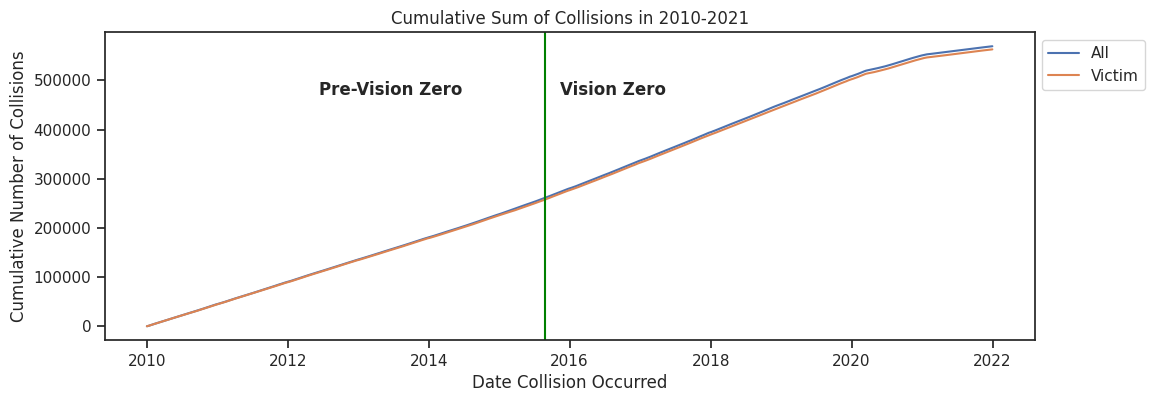

In [7]:
dfin["all"] = True

c_all = pd.DataFrame(dfin.groupby(dfin["dttm_occurred"].dt.date)["all"].sum())
c_all = c_all.cumsum().rename(columns={"all":"All"})
c_all

c_victim = pd.DataFrame(dfin[["victim"]].groupby(dfin["dttm_occurred"].dt.date)["victim"].sum())
c_victim = c_victim.cumsum().rename(columns={"victim":"Victim"})
c_victim

c = c_all.join(c_victim, how='left', sort=True)
c.fillna(method='ffill', inplace=True)
c


sns.set_theme(style="whitegrid")
sns.set_style("ticks")

fig = plt.figure(figsize=(12,4))
plt.plot(c.All, label="All")
plt.plot(c.Victim, label="Victim")
plt.title("Cumulative Sum of Collisions in 2010-2021")
plt.xlabel("Date Collision Occurred")
plt.ylabel("Cumulative Number of Collisions")

plt.axvline(pd.to_datetime("2015-08-24"), color="green")
font = {'weight': 'bold',
        'size': 12}
plt.text(15500,470000, "Pre-Vision Zero", fontdict=font)
plt.text(16750,470000, "Vision Zero", fontdict=font)


plt.legend(bbox_to_anchor=(1,1,0,0))
plt.grid(False)

There are no sudden jumps or increases in the number of collisions that would indicate that there are specific time periods to look examine in particular. Eric Garcetti signed [Executive Order #10](https://lacity.gov/sites/g/files/wph2121/files/2021-04/garcetti_ed10.pdf) to implement Vision Zero on August 24, 2015. Thus, I decided to zoom in at 2015 to see if there was any immediate effect.

<ipython-input-8-f24773f0d8da>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


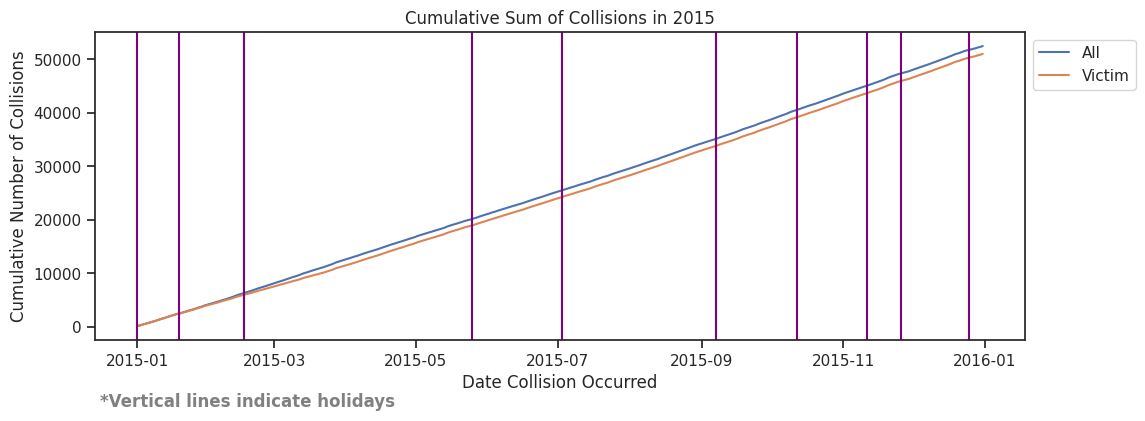

In [8]:
cal = calendar()
cal.holidays()
holidays = cal.holidays(start=dfin.dttm_occurred.dt.date.min(), end=dfin.dttm_occurred.dt.date.max())
holidays_dt = pd.to_datetime(holidays)

holidays_dt_2015 = pd.to_datetime(holidays)[50:60]
holidays_dt_2015

c_all_2015 = pd.DataFrame(dfin[dfin["dttm_occurred"].dt.year==2015].\
                          groupby(dfin["dttm_occurred"].dt.date)["all"].sum())
c_all_2015 = c_all_2015.cumsum().rename(columns={"all":"All"})
c_all_2015

c_victim_2015 = pd.DataFrame(dfin[(dfin.victim) & (dfin.dttm_occurred.dt.year==2015)].\
                             groupby(dfin["dttm_occurred"].dt.date)["victim"].sum())
c_victim_2015 = c_victim_2015.cumsum().rename(columns={"victim":"Victim"})
c_victim_2015

c_2015 = c_all_2015.join(c_victim_2015, how='left', sort=True)
c_2015.fillna(method='ffill', inplace = True)
c_2015

sns.set_theme(style="whitegrid")
sns.set_style("ticks")

fig2 = plt.figure(figsize=(12,4))
plt.plot(c_2015.All, label="All")
plt.plot(c_2015.Victim, label="Victim")
plt.title("Cumulative Sum of Collisions in 2015")
plt.xlabel("Date Collision Occurred")
plt.ylabel("Cumulative Number of Collisions")
[plt.axvline(pd.to_datetime(i), color="purple") for i in holidays_dt_2015]
plt.legend(bbox_to_anchor=(1,1,0,0))
plt.grid(False)

font = {'weight': 'bold',
        "color": "gray",
        'size': 12}
plt.text(16420,-15000, "*Vertical lines indicate holidays", fontdict=font)
plt.show()

There is only a steady increase in collisions. Overall, it seems like there is a victim in most collisions and this is not impacted by Vision Zero. There also does not seem to be any holiday impact.

I then decided to break it down by season, year, month, day, day of week, and time of day. Furthermore, I also wanted to examine if there are any patterns in the victims when I examine the dates/times more closely.

I decided to use the following ranges to group the `victim_age` and `time_occurred`:
   * 0-10
   * 11-20
   * 21-30
   * 31-40
   * 41-50
   * 51-60
   * 61-70
   * 71-80
   * 81-90
   * 91-98

For time of day, I decided to use the following groups (by military time):
   - Night: 22:00-3:59
   - Morning: 4:00-9:59
   - Noon: 10:00-15:59
   - Evening: 16-21:59

In [9]:
bins = range(0,101,10)
names = ["0-10","11-20","21-30","31-40","41-50","51-60","61-70","71-80","81-90","91-98"]
dfin["age_range"] = pd.cut(dfin["victim_age"],bins,labels=names)


dfin["hour"] = dfin["dttm_occurred"].dt.hour

dfin['time_of_day'] = pd.cut(dfin["hour"],[0,4,10,16,22,24],
                             labels=['Night','Morning','Noon','Evening','Night '],
                             right=False).str.strip()

# #double-check cut is correct.
dfin[dfin["hour"].isin([0,4,10,16,22,24])][["hour","time_of_day"]].value_counts()

,,count
hour,time_of_day,
16,Evening,35896
10,Noon,24795
22,Night,21421
0,Night,14663
4,Morning,6380


In [10]:
dfin["time_of_day"].value_counts()

,count
time_of_day,
Evening,193137
Noon,184706
Morning,100382
Night,91066


In [11]:
def grapher(df, var):
    sns.set_theme(style="whitegrid")
    sns.set_style("ticks")

    df[["All","Victims"]].plot(kind="bar",edgecolor="black", figsize=(18,4))
    plt.ylabel("Number of Collisions")
    plt.xlabel(var)
    plt.xticks(rotation=0)
    plt.title("Number of Collisions by "+var)
    plt.legend(bbox_to_anchor=(1,1,0,0))
    plt.tight_layout()
    plt.grid(False)

    figure, ax = plt.subplots(1,3,sharey=True,figsize=(18,4), facecolor="white")

    df[["0-10","11-20","21-30",
        "31-40","41-50","51-60","61-70","71-80","81-90","91-98"]].plot(ax=ax[0],
                                                                       kind="bar",
                                                                       edgecolor="black",
                                                                       stacked=True,
                                                                      color = ["red",
                                                                               "orange",
                                                                               "yellow",
                                                                               "green",
                                                                               "blue",
                                                                              "indigo",
                                                                               "olive",
                                                                               "brown",
                                                                              "violet",
                                                                              "gray"])

    ax[0].legend(bbox_to_anchor=(0,0,.4,-.25))
    ax[0].set_title("Number of Collisions by Victim Age")
    ax[0].set_ylabel("Number of Collisions")
    ax[0].grid(False)

    df[["Male",
        "Female",
        "Other/Unknown"]].plot(ax=ax[1],
                               kind="bar",
                               edgecolor="black",
                               stacked=True,
                              color = ["cyan","purple","gray"])

    ax[1].legend(bbox_to_anchor=(0,0,.7,-.3))
    ax[1].set_title("Number of Collisions by Victim Sex")
    ax[1].grid(False)

    df[['Hispanic/Latin/Mexican', 'White','Black', 'Asian',
        'Native Hawaiian/Pacific Islander','Other','Unknown']].plot(ax=ax[2],
                                             kind="bar",
                                             edgecolor="black",
                                             stacked=True,
                                             color = ["azure","yellowgreen","olive","coral",
                                                     "chocolate","plum","gray"])

    ax[2].legend(bbox_to_anchor=(0,0,1,-.3))
    ax[2].set_title("Number of Collisions by Victim Descent")
    ax[2].grid(False)

In [12]:
dfin["year"] = dfin["dttm_occurred"].dt.year

year_a = pd.DataFrame(dfin["year"].value_counts()).rename(columns = {"count":"All"})
year_a


year_v = pd.DataFrame(dfin[dfin["victim"]]["year"].value_counts()).rename(columns = {"count":"Victims"})
year_v

year_va = dfin.groupby("year")["age_range"]\
                     .value_counts().unstack()

year_vs = dfin.groupby("year")["victim_sex_clean"]\
                     .value_counts().unstack()

year_vd = dfin.groupby("year")["victim_descent_clean"]\
                     .value_counts().unstack()

year = year_a.join([year_v, year_va, year_vs, year_vd])
year = year.reindex(range(2010,2022))
year

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
year,,,,,,,,,,,,,,,,,,,,,,,
2010,45098,44708,2,890,10527,8761,7771,5513,2379,911,349,468,17526,26976,205,11,2284,6234,16070,181,6285,883,12754
2011,45276,44828,0,940,10799,8807,7933,5360,2506,871,354,664,17534,26945,343,17,2355,5956,16466,200,6447,981,12398
2012,45406,45143,0,954,10968,8611,7887,5399,2596,936,328,746,17780,26755,603,19,2367,5917,16393,199,6615,1309,12314
2013,45035,44565,0,860,10668,8474,7524,5450,2605,910,320,703,17102,26703,707,9,2387,5711,16159,296,6781,1575,11538
2014,46951,46349,0,872,11439,8896,7682,5748,2706,998,334,566,18084,27304,867,12,2457,6179,16794,223,7142,1845,11514
2015,52487,51021,0,957,12652,9706,8323,6256,3089,1064,324,695,19610,30369,1014,17,2497,6528,19125,180,8296,2370,11918
2016,56532,55967,0,1022,13711,11068,8762,6807,3480,1140,332,655,21277,32851,1793,19,2471,7388,21092,201,8886,3334,12396
2017,57726,57098,0,1033,13720,11415,9064,6901,3695,1212,366,798,21466,33311,2219,14,2553,7505,22037,209,8908,3795,11896
2018,57159,56092,0,982,13513,11472,8969,7159,3772,1305,339,748,20988,32892,2043,18,2519,7448,21803,215,8394,3523,11845


In [13]:
dfin["month"] = dfin["dttm_occurred"].dt.month

month_a = pd.DataFrame(dfin["month"].value_counts()).rename(columns = {"count":"All"})

month_v = pd.DataFrame(dfin[dfin["victim"]]["month"].value_counts()).rename(columns = {"count":"Victims"})

month_va = dfin.groupby("month")["age_range"]\
                     .value_counts().unstack()

month_vs = dfin.groupby("month")["victim_sex_clean"]\
                     .value_counts().unstack()#\

month_vd = dfin.groupby("month")["victim_descent_clean"]\
                     .value_counts().unstack()

month = month_a.join([month_v,month_va, month_vs, month_vd])
month = month.reindex(range(1,13))
month.rename(index = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}, inplace=True)

month

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
month,,,,,,,,,,,,,,,,,,,,,,,
January,46775,46193,3,1513,11048,9133,7857,5736,2819,1031,309,618,17456,27375,1150,19,2302,6136,17435,191,6677,2120,11004
February,45067,44114,4,1431,10616,8894,7287,5347,2744,937,280,621,16707,26088,1143,12,2169,5828,16672,212,6340,2170,10453
March,49021,47941,3,1468,11533,9512,7908,5769,2960,993,324,624,18013,28429,1304,18,2225,6444,17999,216,7113,2439,11217
April,45220,44740,2,1426,10808,8916,7448,5364,2700,932,298,612,16963,26400,1193,14,2088,6109,16910,182,6587,2155,10454
May,46537,46132,5,1724,11065,9154,7607,5606,2812,951,298,669,17510,27215,1188,12,2149,6462,17275,185,6732,2106,10922
June,45919,45528,3,1765,10900,9043,7365,5591,2730,988,297,598,17159,26829,1318,7,2168,6208,16839,169,6822,2240,10784
July,47524,47142,7,1745,11413,9150,7734,5795,2886,983,327,663,17579,27945,1366,17,2238,6381,17823,209,6897,2342,10920
August,49662,49298,9,1951,11926,9612,8079,5971,3020,993,324,721,18422,29149,1450,12,2287,6562,18625,210,7157,2505,11593
September,47760,47385,2,1881,11324,9369,7598,5872,2860,1053,304,647,17878,27820,1416,11,2246,6191,18036,199,6776,2507,11086


In [14]:
dfin["day"] = dfin["dttm_occurred"].dt.day

day_a = pd.DataFrame(dfin["day"].value_counts()).rename(columns = {"count":"All"})


day_v = pd.DataFrame(dfin[dfin["victim"]]["day"].value_counts()).rename(columns = {"count":"Victims"})

day_va = dfin.groupby("day")["age_range"]\
                     .value_counts().unstack()

day_vs = dfin.groupby("day")["victim_sex_clean"]\
                     .value_counts().unstack()#\

day_vd = dfin.groupby("day")["victim_descent_clean"]\
                     .value_counts().unstack()

day = day_a.join([day_v,day_va, day_vs, day_vd])
day = day.reindex(range(1,32))
day

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
day,,,,,,,,,,,,,,,,,,,,,,,
1,19355,19127,1,677,4639,3747,3017,2343,1187,438,117,261,7161,11348,521,8,891,2661,7275,61,2828,926,4353
2,18917,18734,2,679,4493,3685,2977,2340,1177,428,108,247,6981,11104,549,3,838,2622,6961,81,2718,958,4422
3,19012,18802,1,678,4449,3784,3050,2317,1178,458,122,235,7103,11077,528,6,868,2580,7093,90,2680,937,4419
4,18567,18352,2,652,4266,3650,2995,2304,1138,423,134,263,6895,10896,484,6,855,2413,7166,86,2653,894,4165
5,18786,18562,1,687,4423,3710,3008,2232,1151,444,109,253,7069,10868,531,3,912,2472,6928,76,2701,946,4399
6,18822,18611,1,658,4489,3658,3040,2261,1224,402,138,253,6966,11036,518,9,898,2573,7013,82,2754,900,4266
7,18538,18312,1,656,4338,3767,3035,2156,1134,401,132,252,6893,10826,500,4,854,2507,6875,71,2706,870,4303
8,18656,18445,3,646,4394,3588,3060,2340,1126,382,120,267,7025,10816,521,8,829,2549,6889,84,2666,950,4348
9,18890,18672,1,672,4535,3730,3005,2251,1160,377,136,262,6994,11089,520,6,830,2470,7074,87,2785,948,4366


In [15]:
dfin["date_temp"] = dfin.month*100 + dfin.day
dfin['season'] = (pd.cut(dfin.date_temp,[0,321,621,922,1221,1300],
                       labels=['Winter','Spring','Summer','Autumn','Winter '])
                  .str.strip()
               )
dfin[["season","month"]].value_counts().sort_index()

season_a = pd.DataFrame(dfin["season"].value_counts()).rename(columns = {"count":"All"})


season_v = pd.DataFrame(dfin[dfin["victim"]]["season"].value_counts()).rename(columns = {"count":"Victims"})

season_va = dfin.groupby("season")["age_range"]\
                     .value_counts().unstack()

season_vs = dfin.groupby("season")["victim_sex_clean"]\
                     .value_counts().unstack()#\

season_vd = dfin.groupby("season")["victim_descent_clean"]\
                     .value_counts().unstack()

season = season_a.join([season_v,season_va, season_vs, season_vd])
season = season.reindex(["Spring","Summer","Autumn","Winter"])

season

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
season,,,,,,,,,,,,,,,,,,,,,,,
Spring,138754,137289,11,4763,33054,27329,22553,16604,8355,2866,917,1913,51968,81053,3651,37,6388,18932,51399,548,20349,6518,32306
Summer,146194,145059,19,5687,34982,28296,23707,17837,8778,3024,939,2011,54289,85702,4301,41,6871,19373,54852,629,21016,7440,33858
Autumn,145164,143874,9,5557,34411,28507,23155,17638,9016,3228,981,1900,54387,84366,4279,55,6786,18831,54671,598,20811,7388,33655
Winter,139179,136729,11,4482,32645,27103,22781,16784,8534,2980,881,1907,51351,81161,3627,45,6683,18266,51730,598,19924,6707,31937


In [16]:
dfin["day_of_week"] = dfin.dttm_occurred.dt.day_name()
dow_a = pd.DataFrame(dfin["day_of_week"].value_counts()).rename(columns = {"count":"All"})


dow_v = pd.DataFrame(dfin[dfin["victim"]]["day_of_week"].value_counts()).rename(columns = {"count":"Victims"})

dow_va = dfin.groupby("day_of_week")["age_range"]\
                     .value_counts().unstack()

dow_vs = dfin.groupby("day_of_week")["victim_sex_clean"]\
                     .value_counts().unstack()#\

dow_vd = dfin.groupby("day_of_week")["victim_descent_clean"]\
                     .value_counts().unstack()


dow = dow_a.join([dow_v,dow_va, dow_vs, dow_vd])
dow = dow.reindex(["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"])

dow

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
day_of_week,,,,,,,,,,,,,,,,,,,,,,,
Sunday,74972,74039,4,3038,18372,14172,11483,8309,4050,1349,405,1014,25619,45559,2458,21,3193,9900,28939,308,11126,4338,15672
Monday,78605,77758,10,2672,18256,15404,12853,9777,4915,1716,521,1172,29444,45822,2112,25,3745,10445,29218,337,11699,3734,18071
Tuesday,80082,79226,6,2743,18643,15956,13279,10110,5016,1858,545,1136,31000,45768,2089,20,3935,10602,29414,351,11416,3625,19378
Wednesday,80719,79893,5,2748,18986,16035,13242,10154,5164,1811,572,1121,31094,46305,2134,24,3847,10715,29424,330,11568,3773,19724
Thursday,82048,81148,8,2863,19140,16223,13646,10066,5221,1842,569,1075,31260,47313,2159,31,3949,10893,29896,345,11621,3790,20069
Friday,90328,89382,8,3263,21729,17515,14736,11060,5660,1886,619,1185,34388,52162,2393,27,4283,11980,34002,343,12748,4295,21136
Saturday,82537,81505,9,3162,19966,15930,12957,9387,4657,1636,487,1028,29190,49353,2513,30,3776,10867,31759,359,11922,4498,17706


In [17]:
tod_a = pd.DataFrame(dfin["time_of_day"].value_counts()).rename(columns = {"count":"All"})


tod_v = pd.DataFrame(dfin[dfin["victim"]]["time_of_day"].value_counts()).rename(columns = {"count":"Victims"})

tod_va = dfin.groupby("time_of_day")["age_range"]\
                     .value_counts().unstack()

tod_vs = dfin.groupby("time_of_day")["victim_sex_clean"]\
                     .value_counts().unstack()#\

tod_vd = dfin.groupby("time_of_day")["victim_descent_clean"]\
                     .value_counts().unstack()

tod = tod_a.join([tod_v,tod_va, tod_vs, tod_vd])
tod = tod.reindex(["Morning","Noon","Evening","Night"])
tod

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
time_of_day,,,,,,,,,,,,,,,,,,,,,,,
Morning,100382,99281,2,2940,21734,20763,17668,13086,6167,2165,632,1434,38961,57115,2679,32,4747,12852,40380,425,13573,4821,21775
Noon,184706,182906,9,5902,40561,35586,31088,25055,13882,5551,1855,2606,72928,104971,4182,50,9163,25608,66016,764,25828,7616,46772
Evening,193137,191230,31,7315,48585,38501,31085,23146,11524,3593,1058,1933,73835,111805,4875,67,9418,25829,74149,844,26697,8582,44647
Night,91066,89534,8,4332,24212,16385,12355,7576,3110,789,173,1758,26271,58391,4122,29,3400,11113,32107,340,16002,7034,18562


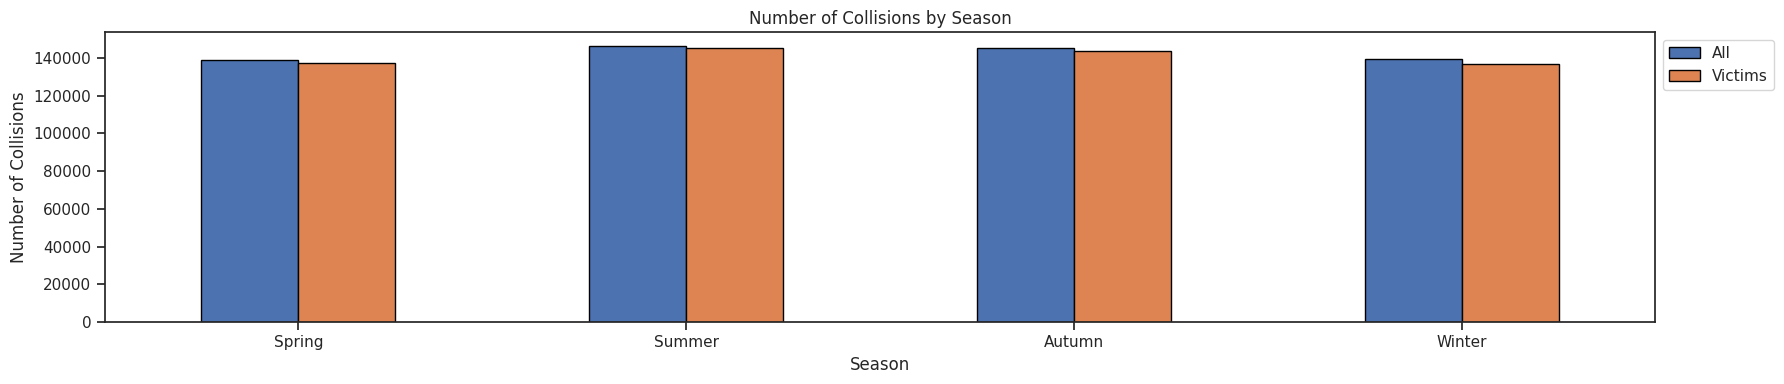

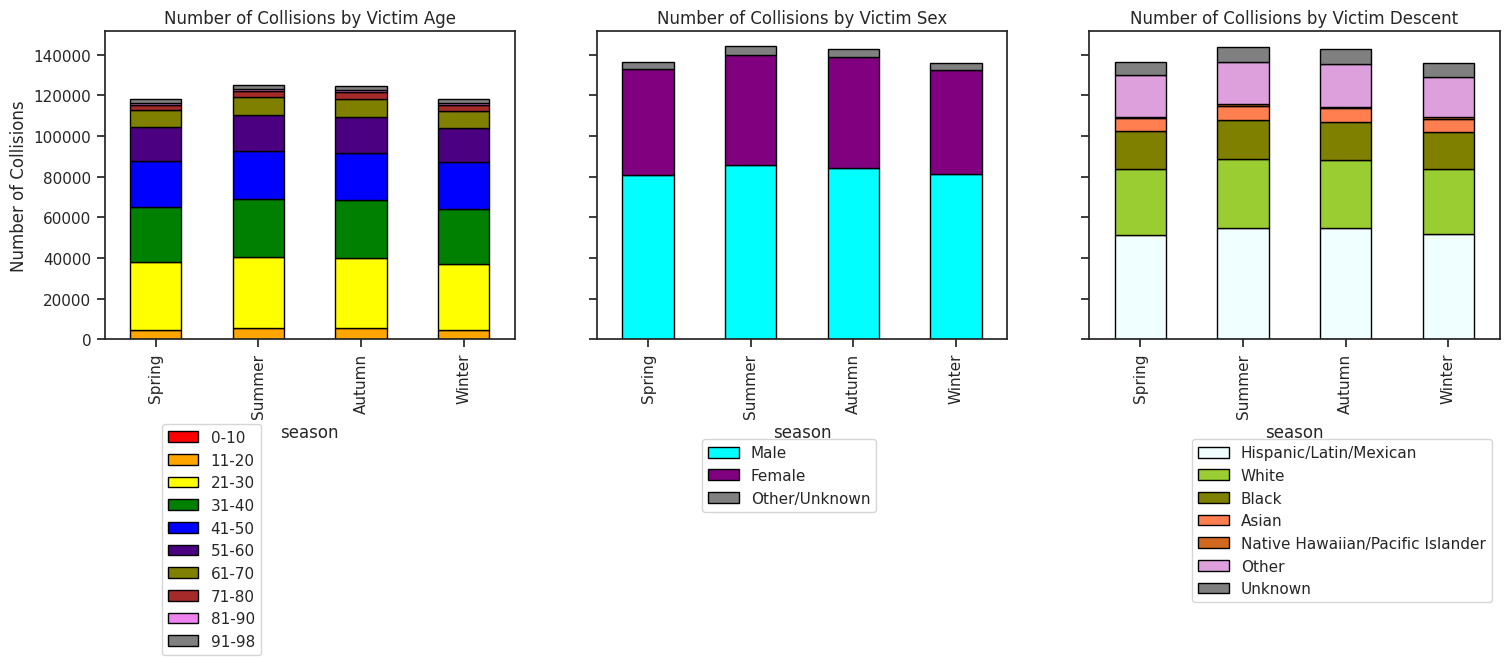

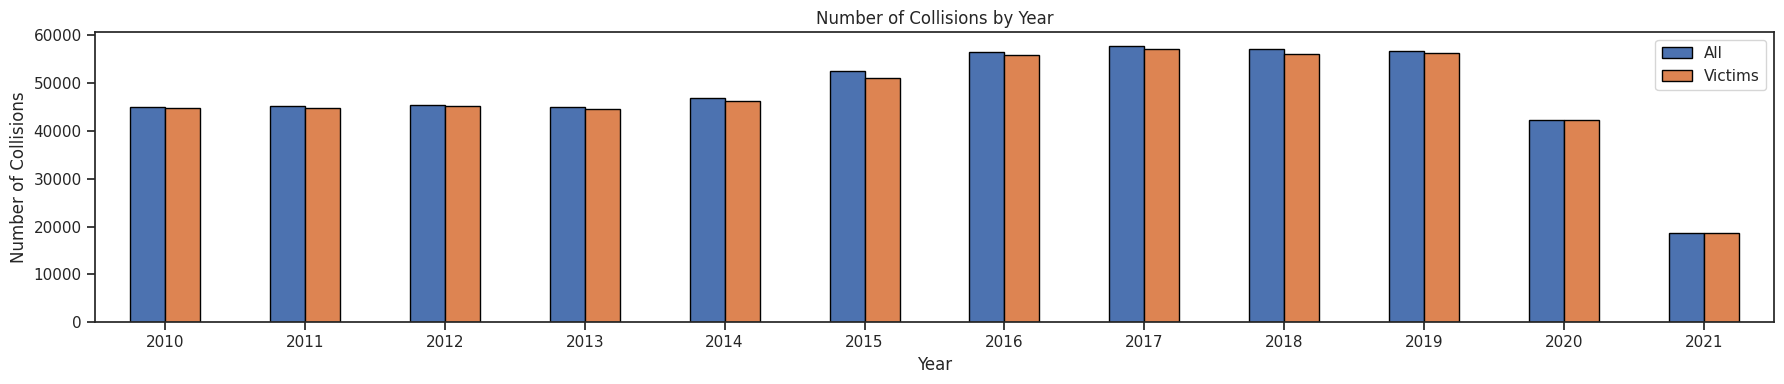

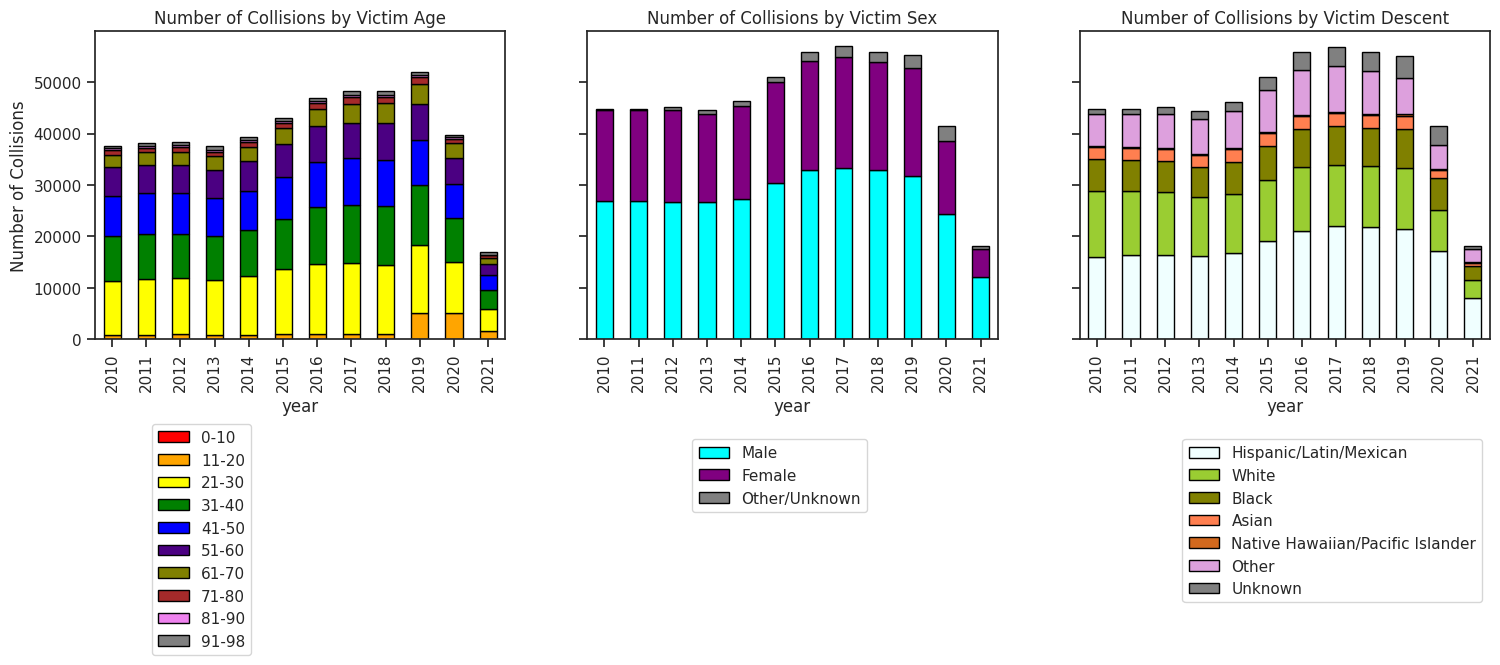

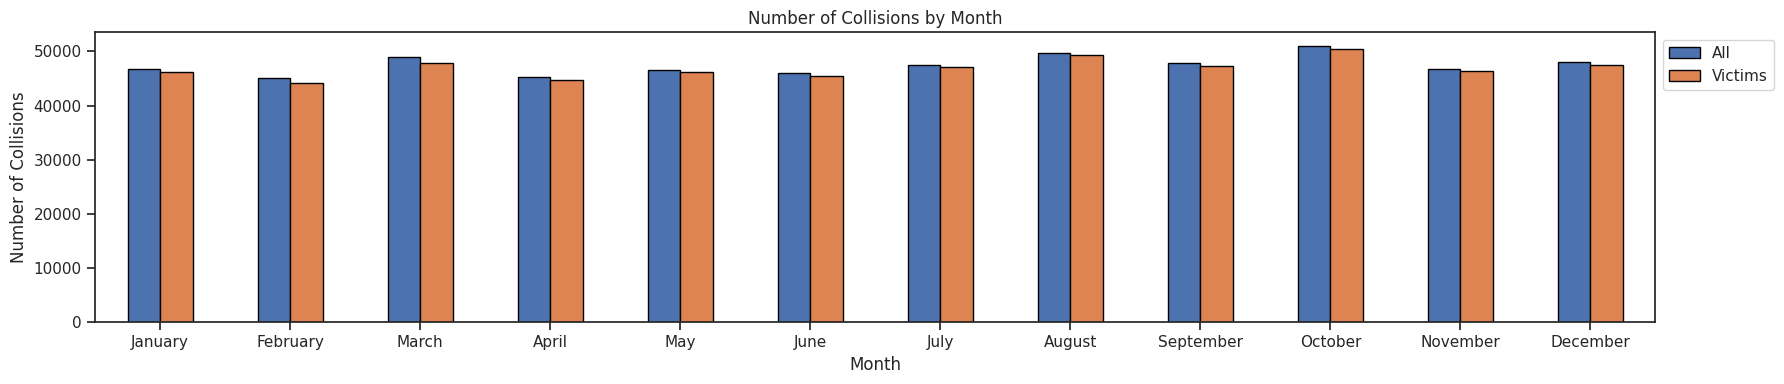

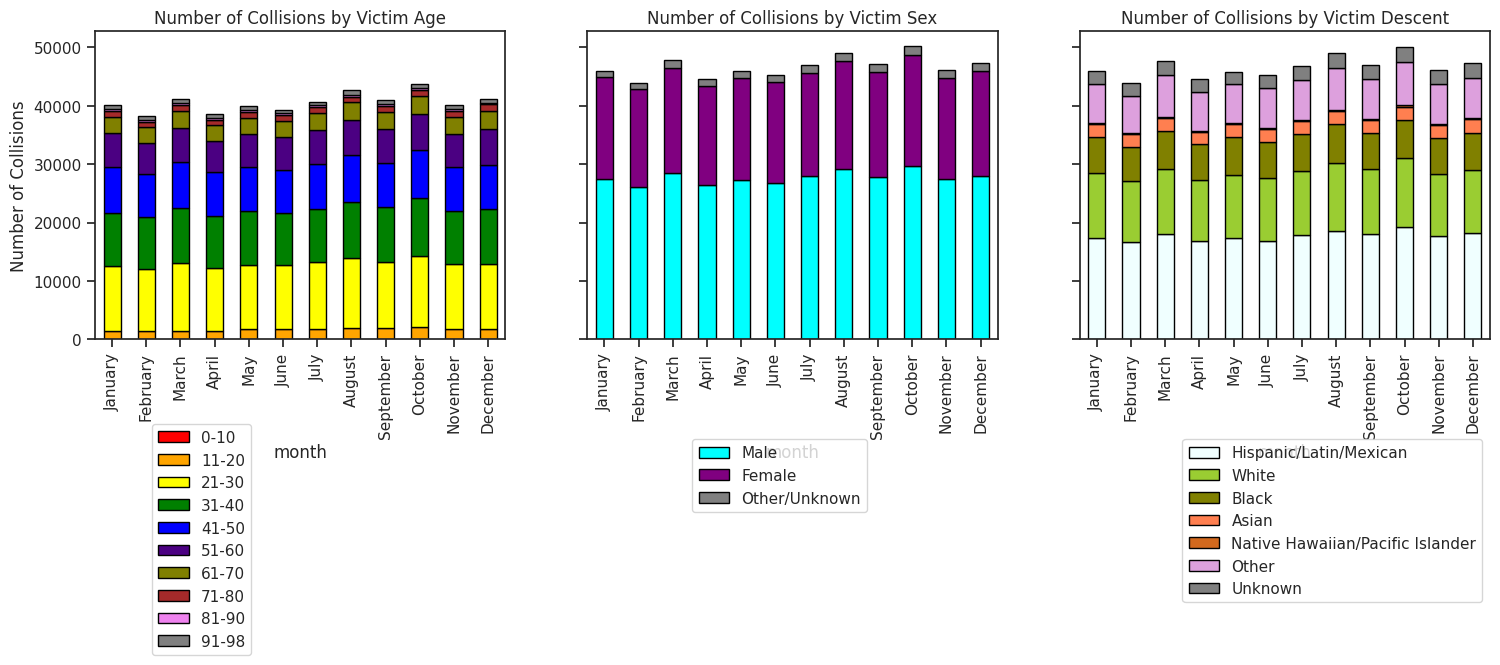

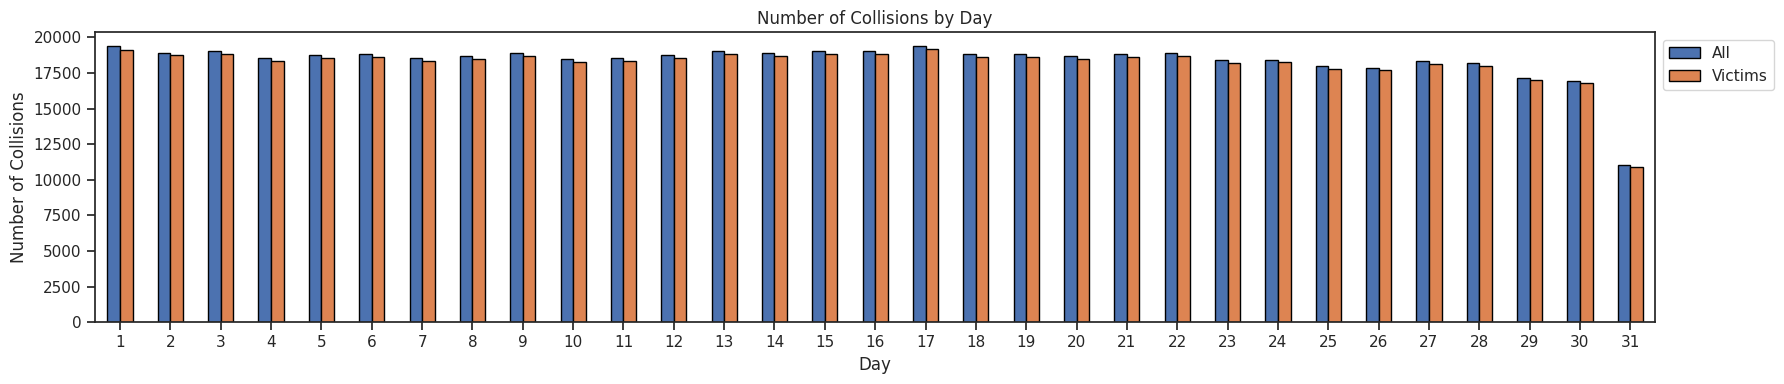

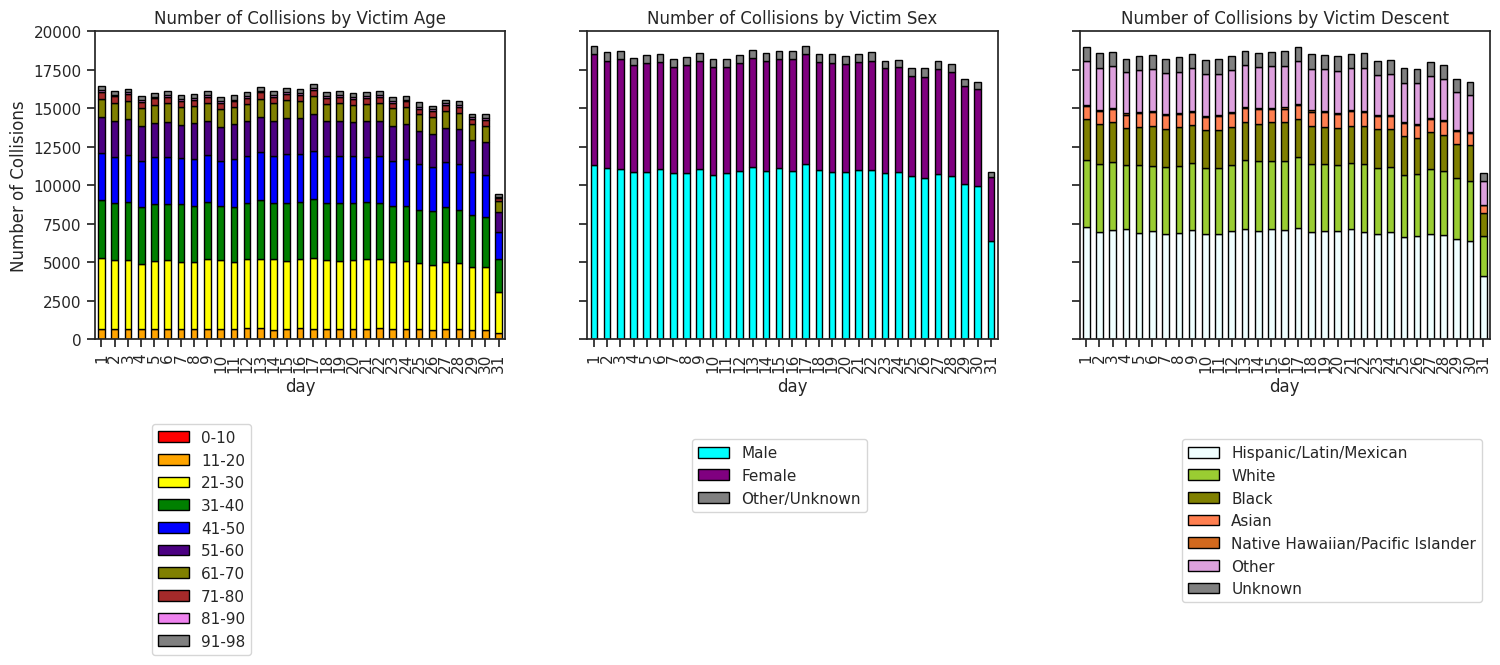

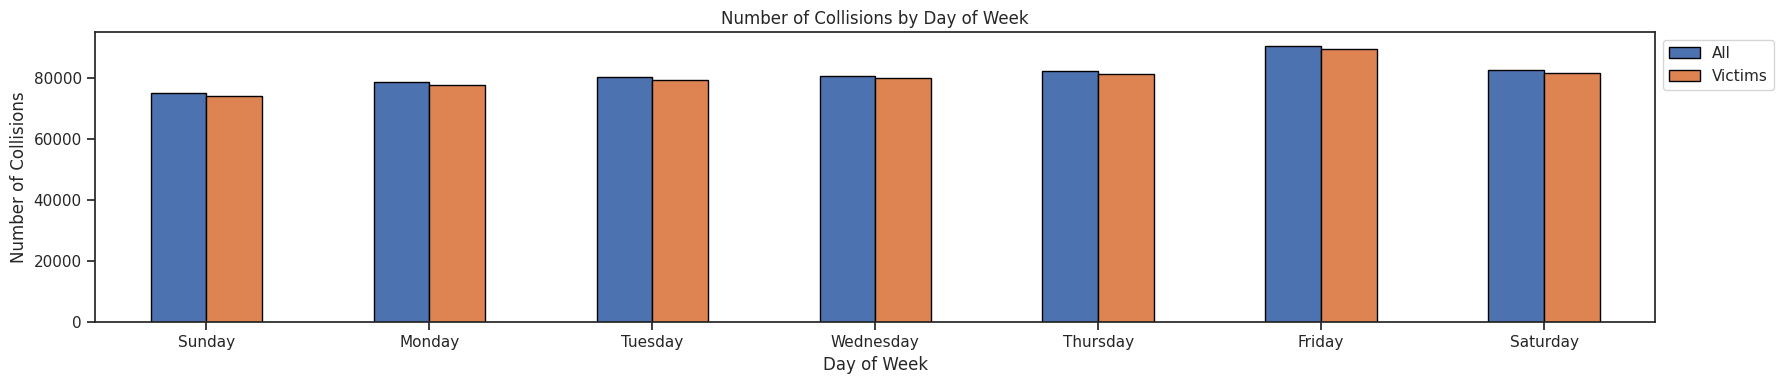

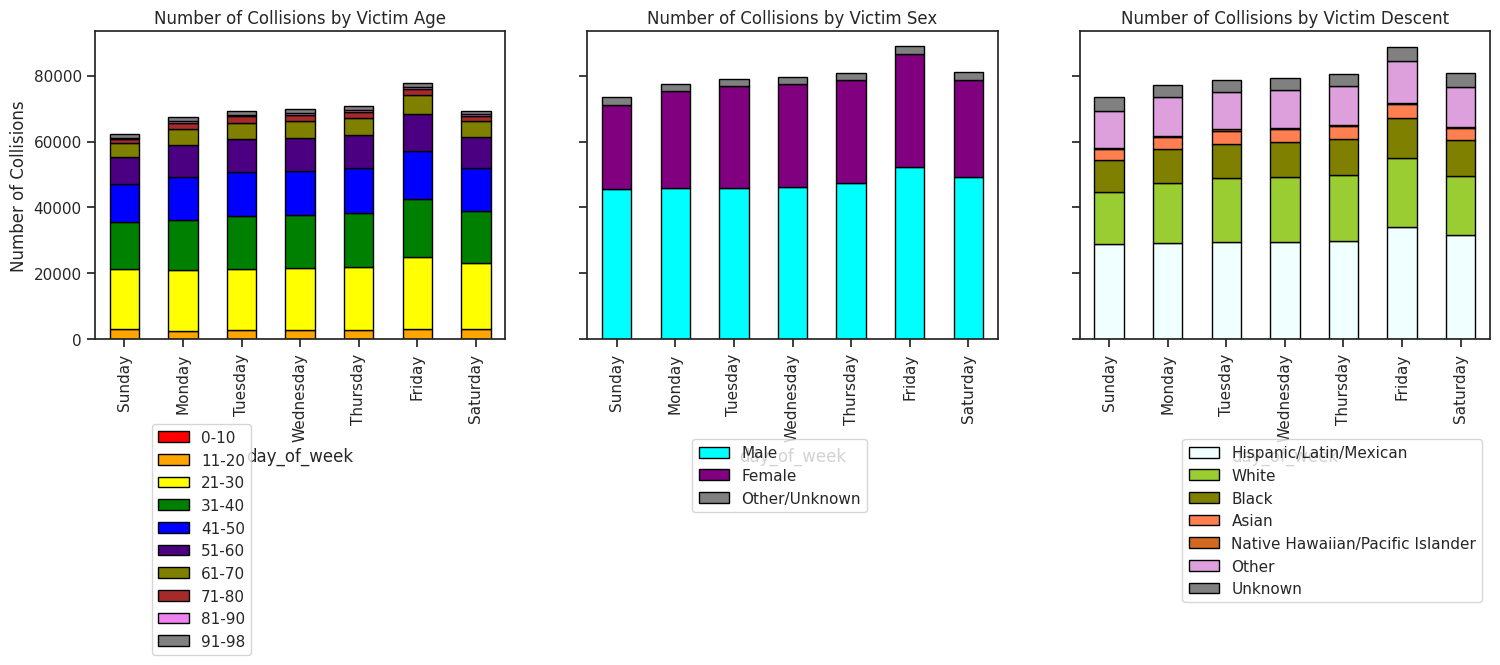

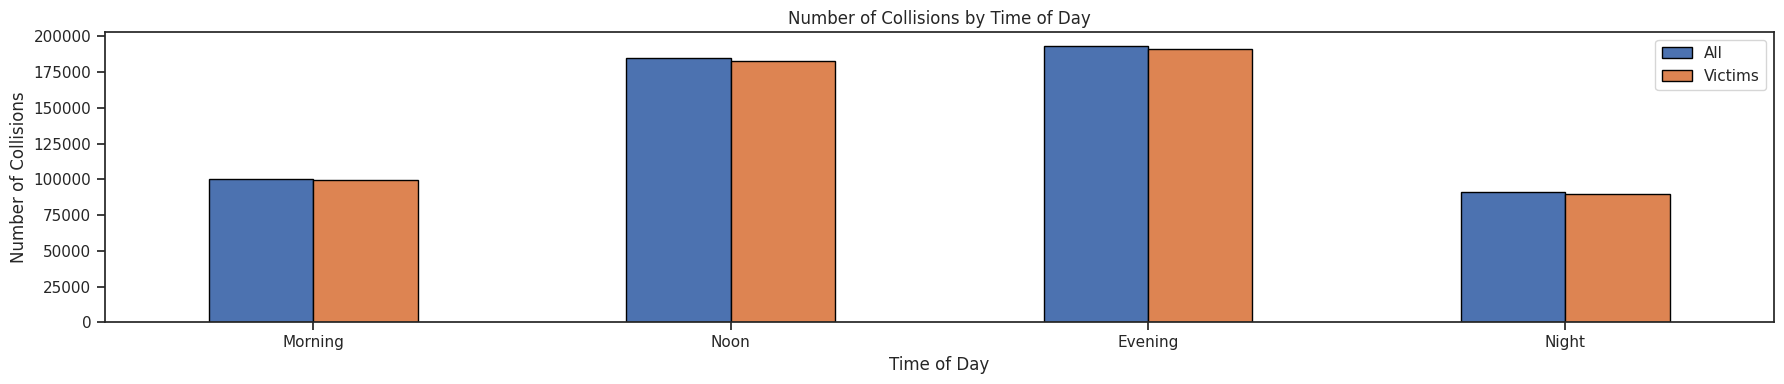

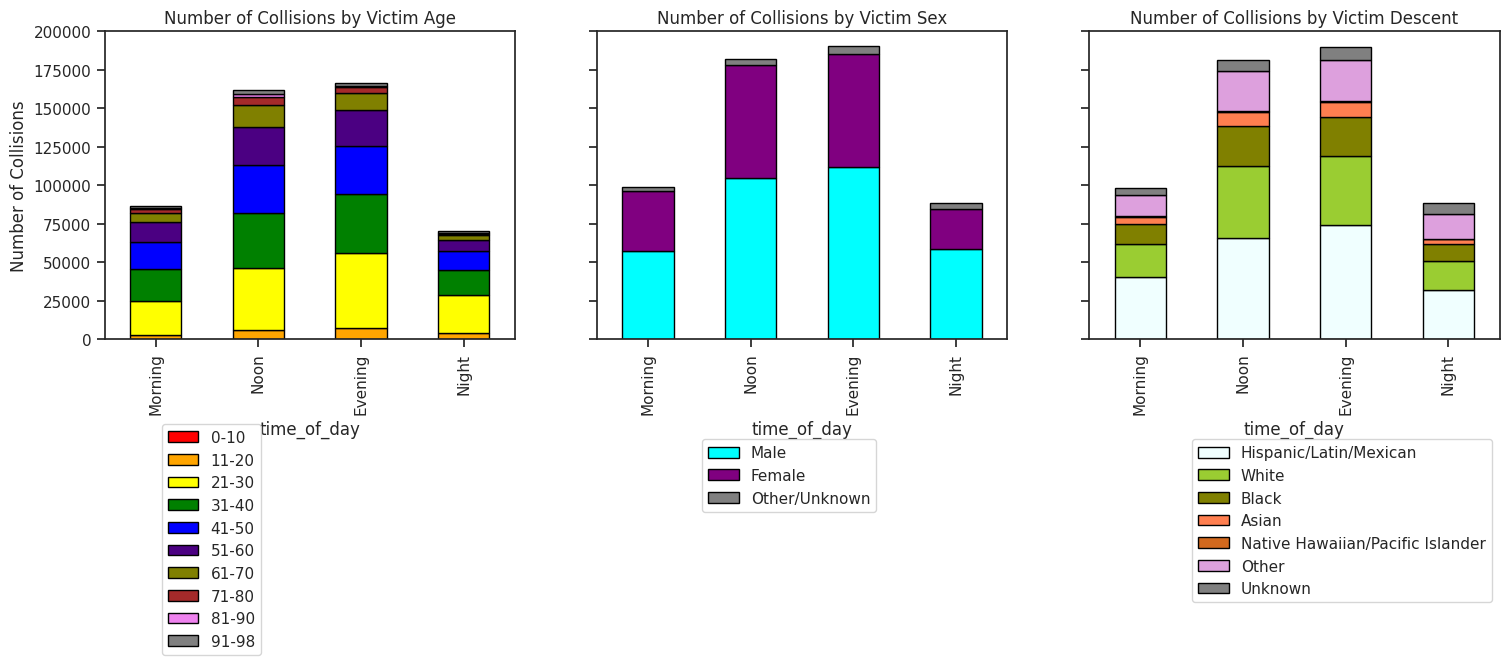

In [18]:
grapher(season,"Season")
grapher(year,"Year")
grapher(month,"Month")
grapher(day,"Day")
grapher(dow,"Day of Week")
grapher(tod,"Time of Day")

When looking at the graphs:
   * Collisions have **increased since 2015**  except until it reached 2020. This could be attributed to the decrease in traffic due to Covid. With less cars on the road, the less of a chance for there to be accidents.


It appears that Vision Zero did not decrease collisions at all, but I could search for clues on where to look at for further research.
   * It appears that collisions **remained steady across seasons** and this is consistent with the cumulative sum graph.
   * The collisions are **not dependent on month**.
   * There less collisions on the 31, but this could possibly be because there are months when there aren't 31 days.
   * Most collisions occur during **noon and evening**. More research is needed, but this could be due to the fatigue from working in the morning while having due to deal with rush hour going home. (People in LA know that if they go out during a certain time of day, they will remain in traffic for a period of time)
   * Most collisions occur during **Friday**.
   
Most of the collisions have victims, and this is not dependent on date or time. I can examine the victims by looking at their sex, age, and descent. It looks like the victims are usually:
   * 21-30 year olds
   * Male
   * Hispanic/Latin/Mexican

## Location, Location, Location

I sought to answer these three questions about the locations where most collisions occur:

- Which streets or intersections have the most collisions reported?
- What type of structure or location where the most incidents took place?
- Which precincts received the most collisions reports, accounting for area (see reporting districts additional column rd_area)

I first examined the streets that these collisions occurred. I combined the `address_clean` and `cross_street_clean` in order to figure out the most intersections. Because an intersection is the same on a map regardless if the street is a cross street or the street, I had to create an `intersection_clean` column which did not care about the order. I was able to find the 5 most dangerous intersections and plot them on a heat map showing all the collisions.

In [19]:
dfin["intersection_temp"] = dfin["address_clean"] + ", " + dfin["cross_street_clean"]
inter1 = (dfin["address_clean"] + ", " + dfin["cross_street_clean"]).tolist()
inter2 = (dfin["cross_street_clean"] + ", " + dfin["address_clean"]).tolist()

In [20]:
inter_dict = {}
for i in range(len(inter1)):
    if (inter1[i] not in inter_dict.keys()) and (inter2[i] not in inter_dict.keys()):
        inter_dict[inter1[i]] = [inter1[i],inter2[i]]
    else:
        continue
inter_dict

{'JEFFERSON BL, NORMANDIE AV': ['JEFFERSON BL, NORMANDIE AV',
  'NORMANDIE AV, JEFFERSON BL'],
 'JEFFERSON BL, W WESTERN': ['JEFFERSON BL, W WESTERN',
  'W WESTERN, JEFFERSON BL'],
 'N BROADWAY, W EASTLAKE AV': ['N BROADWAY, W EASTLAKE AV',
  'W EASTLAKE AV, N BROADWAY'],
 '1ST, CENTRAL': ['1ST, CENTRAL', 'CENTRAL, 1ST'],
 'MARTIN LUTHER KING JR, ARLINGTON AV': ['MARTIN LUTHER KING JR, ARLINGTON AV',
  'ARLINGTON AV, MARTIN LUTHER KING JR'],
 'MAIN, JOHNSTON': ['MAIN, JOHNSTON', 'JOHNSTON, MAIN'],
 'I ST, KING AV': ['I ST, KING AV', 'KING AV, I ST'],
 'CRENSHAW BL, 28TH ST': ['CRENSHAW BL, 28TH ST', '28TH ST, CRENSHAW BL'],
 'WESTERN AV, 36TH ST': ['WESTERN AV, 36TH ST', '36TH ST, WESTERN AV'],
 nan: [nan, nan],
 'N BROADWAY, W HANCOCK ST': ['N BROADWAY, W HANCOCK ST',
  'W HANCOCK ST, N BROADWAY'],
 'AVENUE 26, BARRANCA ST': ['AVENUE 26, BARRANCA ST',
  'BARRANCA ST, AVENUE 26'],
 'GERTRUDE ST, E 4TH ST': ['GERTRUDE ST, E 4TH ST', 'E 4TH ST, GERTRUDE ST'],
 'CESAR E CHAVEZ AV, N BRITT

In [21]:
inter_df_temp = pd.DataFrame.from_dict(inter_dict, orient="index", columns = ["inter1", "inter2"])

In [22]:
inter_df = pd.melt(inter_df_temp, ignore_index=False, value_name = "intersection_temp").sort_index()
inter_df["intersection_clean"] = inter_df.index
inter_df

,variable,intersection_temp,intersection_clean
"0 ST, AVALON BL",inter1,"0 ST, AVALON BL","0 ST, AVALON BL"
"0 ST, AVALON BL",inter2,"AVALON BL, 0 ST","0 ST, AVALON BL"
"0HIO, SAWTELLE",inter1,"0HIO, SAWTELLE","0HIO, SAWTELLE"
"0HIO, SAWTELLE",inter2,"SAWTELLE, 0HIO","0HIO, SAWTELLE"
"1 ST, CHEESBROUGHS LN",inter1,"1 ST, CHEESBROUGHS LN","1 ST, CHEESBROUGHS LN"
...,...,...,...
"ZOO, ZOO",inter2,"ZOO, ZOO","ZOO, ZOO"
"ZUNIGA LN, INDIANA AV",inter1,"ZUNIGA LN, INDIANA AV","ZUNIGA LN, INDIANA AV"
"ZUNIGA LN, INDIANA AV",inter2,"INDIANA AV, ZUNIGA LN","ZUNIGA LN, INDIANA AV"
NaN,inter1,NaN,NaN


In [23]:
inter_df.drop("variable", axis=1, inplace=True)
inter_df

,intersection_temp,intersection_clean
"0 ST, AVALON BL","0 ST, AVALON BL","0 ST, AVALON BL"
"0 ST, AVALON BL","AVALON BL, 0 ST","0 ST, AVALON BL"
"0HIO, SAWTELLE","0HIO, SAWTELLE","0HIO, SAWTELLE"
"0HIO, SAWTELLE","SAWTELLE, 0HIO","0HIO, SAWTELLE"
"1 ST, CHEESBROUGHS LN","1 ST, CHEESBROUGHS LN","1 ST, CHEESBROUGHS LN"
...,...,...
"ZOO, ZOO","ZOO, ZOO","ZOO, ZOO"
"ZUNIGA LN, INDIANA AV","ZUNIGA LN, INDIANA AV","ZUNIGA LN, INDIANA AV"
"ZUNIGA LN, INDIANA AV","INDIANA AV, ZUNIGA LN","ZUNIGA LN, INDIANA AV"
NaN,NaN,NaN


In [24]:
inter_df.intersection_temp.value_counts()

,count
intersection_temp,
"ARLETA AV, ARLETA AV",2
"SUNLAND, SUNLAND",2
"WILBUR, WILBUR",2
"4TH, 4TH",2
"BORDEN AV, BORDEN AV",2
...,...
"FAIR AV, VICTORY",1
"VICTORY, FAIR AV",1
"VICTORY BL, FAIR AV",1


In [25]:
inter_df.drop_duplicates(inplace=True) #191730

In [26]:
dfin = dfin.merge(inter_df,
                  on="intersection_temp")
dfin.dr_number.value_counts()

,count
dr_number,
190319651,1
160911640,1
160909706,1
160905467,1
160909995,1
...,...
121011241,1
121007805,1
121006775,1


In [27]:
dfin["intersection_clean"].value_counts()

,count
intersection_clean,
"SEPULVEDA BL, SHERMAN WY",478
"ROSCOE BL, VAN NUYS BL",477
"WOODMAN AV, SHERMAN WY",422
"WESTERN AV, SLAUSON AV",415
"TAMPA AV, NORDHOFF ST",408
...,...
"ALLESANDRO ST, LOMA VISTA PL",1
"N AVENUE 64, N REPTON ST",1
"WAVERLY AV, ROKEBY ST",1


In [28]:
dfin[["intersection_clean", "location"]].value_counts()

intersection_clean              location            
SEPULVEDA BL, SHERMAN WY        (34.2012, -118.4662)    440
ROSCOE BL, VAN NUYS BL          (34.2216, -118.4488)    414
WESTERN AV, SLAUSON AV          (33.9892, -118.3089)    400
TAMPA AV, NORDHOFF ST           (34.2355, -118.5536)    390
WOODMAN AV, SHERMAN WY          (34.2012, -118.4313)    378
                                                       ... 
HIAWATHA ST, TOPANGA CANYON BL  (34.2661, -118.6153)      1
                                (34.2591, -118.6073)      1
HIAWATHA ST, TOPANGA CANYON     (34.2591, -118.6061)      1
HIAWATHA ST, SWINTON AV         (34.2593, -118.4859)      1
ZUNIGA LN, INDIANA AV           (34.0591, -118.1965)      1
Name: count, Length: 146881, dtype: int64

The most dangerous intersection is Sepulveda Bl and Sherman Wy where 440 collisions occurred during 2010-2021. [ABC7](https://abc7.com/crosstown-la-study-van-nuys-intersections-county-most-dangerous/5930031/) has also reported this as the most dangerous intersection.

![sepulveda_sherman.png](sepulveda_sherman.png)

In [29]:
lat = dfin["latitude"][np.logical_not(np.isnan(dfin["latitude"]))]
lon = dfin["longitude"][np.logical_not(np.isnan(dfin["longitude"]))]

top5 = dfin[["intersection_clean","latitude","longitude"]].value_counts().reset_index(name="counts").head()
top5

,intersection_clean,latitude,longitude,counts
0,"SEPULVEDA BL, SHERMAN WY",34.2012,-118.4662,440
1,"ROSCOE BL, VAN NUYS BL",34.2216,-118.4488,414
2,"WESTERN AV, SLAUSON AV",33.9892,-118.3089,400
3,"TAMPA AV, NORDHOFF ST",34.2355,-118.5536,390
4,"WOODMAN AV, SHERMAN WY",34.2012,-118.4313,378


In [30]:
map = folium.Map(location=[dfin["latitude"].mean(),dfin["longitude"].mean()],
                 zoom_start=8.5,
                 control_scale=True)
HeatMap(list(zip(lat, lon))).add_to(map)

for row in top5.itertuples():
    folium.Marker([row.latitude, row.longitude],
                 popup=row.intersection_clean,
                 icon=folium.Icon(color="red")).add_to(map)
map

Output hidden; open in https://colab.research.google.com to view.

I examined this in the context of Vision Zero to see if these top 5 dangerous intersections were the same prior to its implementation and after the program began. I see that while there are changes in the ordering of which intersections are the most dangerous, all of them are still highly dangerous.

In [31]:
df_intersection_clean = dfin[["dr_number","intersection_clean"]]
df_intersection_clean.dr_number.value_counts() #596832
dfin_p2015 = pd.merge(dfin_p2015,
                      df_intersection_clean,
                      on = ["dr_number"],
                      how = "left")
dfin_2015p = pd.merge(dfin_2015p,
                      df_intersection_clean,
                      on = "dr_number",
                      how = "left")

In [32]:
dfin_p2015.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean,cross_street_clean,location_clean,latitude,longitude,victim_sex_clean,victim_descent_clean,intersection_clean
0,191221593,08/31/2019,08/30/2010,23:11,12,77th Street,1239,3101 3401 3701 3006 3030 3602 3801 1218,16.0,M,H,101.0,STREET,SLAUSON AV,FIGUEROA ST,"(33.9892, -118.2827)",2010-08-30 23:11:00,2019-08-31,True,"3288 days, 0:00:00",3288,906.0,1239.0,12.0,77TH STREET,SOUTH BUREAU,12A49,9.751333e+06,13919.033798,0.043376,0.000088,SLAUSON AV,FIGUEROA ST,"(33.9892, -118.2827)",33.9892,-118.2827,Male,Hispanic/Latin/Mexican,"FIGUEROA ST, SLAUSON AV"
1,120217719,09/10/2012,09/10/2012,14:00,2,Rampart,257,3101 3401 3701 3006 3034 3002 3032,65.0,M,H,108.0,PARKING LOT,6TH ST,COLUMBIA ST,"(34.0558, -118.2663)",2012-09-10 14:00:00,2012-09-10,True,0:00:00,0,626.0,257.0,2.0,RAMPART,CENTRAL BUREAU,2A69,3.282029e+06,8404.045193,0.025202,0.000030,6TH ST,COLUMBIA ST,"(34.0558, -118.2663)",34.0558,-118.2663,Male,Hispanic/Latin/Mexican,"6TH ST, COLUMBIA ST"
2,140221197,11/22/2014,11/21/2014,20:10,2,Rampart,205,3101 3401 3701 3004 3030,31.0,M,H,101.0,STREET,3300 LARISSA DR,NaN,"(34.0859, -118.276)",2014-11-21 20:10:00,2014-11-22,True,"1 day, 0:00:00",1,510.0,205.0,2.0,RAMPART,CENTRAL BUREAU,2A5,7.679574e+06,12110.549041,0.036111,0.000070,3300 LARISSA DR,NaN,"(34.0859, -118.276)",34.0859,-118.2760,Male,Hispanic/Latin/Mexican,NaN
3,140404087,01/03/2014,01/03/2014,09:45,4,Hollenbeck,422,3101 3401 3701 3004 3030 3036,34.0,F,H,101.0,STREET,E DARWIN AV,N EASTLAKE AV,"(34.0677, -118.2064)",2014-01-03 09:45:00,2014-01-03,True,0:00:00,0,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,E DARWIN AV,N EASTLAKE AV,"(34.0677, -118.2064)",34.0677,-118.2064,Female,Hispanic/Latin/Mexican,"E DARWIN AV, N EASTLAKE AV"
4,140417212,11/24/2014,11/24/2014,16:25,4,Hollenbeck,441,3101 3401 3701 3011 3030 3034,14.0,M,O,101.0,STREET,MISSION RD,RICHMOND ST,"(34.059, -118.2164)",2014-11-24 16:25:00,2014-11-24,True,0:00:00,0,608.0,441.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,8.857958e+06,13854.328068,0.042340,0.000080,MISSION RD,RICHMOND ST,"(34.059, -118.2164)",34.0590,-118.2164,Male,Other,"MISSION RD, RICHMOND ST"


In [33]:
dfin_p2015[["intersection_clean","latitude","longitude"]].value_counts()[:10]

,,,count
intersection_clean,latitude,longitude,
"SEPULVEDA BL, SHERMAN WY",34.2012,-118.4662,209
"ROSCOE BL, VAN NUYS BL",34.2216,-118.4488,201
"WOODMAN AV, SHERMAN WY",34.2012,-118.4313,178
"WESTERN AV, SLAUSON AV",33.9892,-118.3089,166
"SHERMAN WY, VAN NUYS BL",34.2012,-118.4487,159
"TAMPA AV, NORDHOFF ST",34.2355,-118.5536,158
"BURBANK BL, SEPULVEDA BL",34.1721,-118.4662,146
"HOLLYWOOD BL, HIGHLAND AV",34.1016,-118.3387,138
"3RD ST, VERMONT AV",34.0691,-118.2917,131


In [34]:
dfin_2015p[["intersection_clean","latitude","longitude"]].value_counts()[:10]

,,,count
intersection_clean,latitude,longitude,
"WESTERN AV, SLAUSON AV",33.9892,-118.3089,234
"TAMPA AV, NORDHOFF ST",34.2355,-118.5536,232
"SEPULVEDA BL, SHERMAN WY",34.2012,-118.4662,231
"ROSCOE BL, VAN NUYS BL",34.2216,-118.4488,213
"BURBANK BL, SEPULVEDA BL",34.1721,-118.4662,208
"WOODMAN AV, SHERMAN WY",34.2012,-118.4313,200
"FIGUEROA ST, MANCHESTER AV",33.9601,-118.2827,198
"DEVONSHIRE ST, RESEDA BL",34.2573,-118.5361,170
"VAN NUYS BL, VANOWEN ST",34.1939,-118.4487,167


When examining the structure or location most incidents took place, I used the `premise_code` and `premise_description`. From before, I know that a factor of 10 separates the top 3: street, parking lot, and sidewalk.

In [35]:
dfin[["premise_code","premise_description"]].value_counts()

,,count
premise_code,premise_description,
101.0,STREET,542235
108.0,PARKING LOT,17995
102.0,SIDEWALK,3038
103.0,ALLEY,1010
104.0,DRIVEWAY,975
...,...,...
405.0,CLOTHING STORE,1
407.0,HARDWARE/BUILDING SUPPLY,1
408.0,AUTO SUPPLY STORE*,1


In [36]:
premise = dfin[["premise_code","premise_description"]].value_counts().reset_index(name="counts")

premise["description2"] = np.where(~premise["premise_code"].isin([101, 108, 102]),
                                           "OTHER",
                                           premise["premise_description"])
premise2 = premise[["description2","counts"]].groupby("description2").sum().reset_index()
premise2
prem_total = np.sum(premise2["counts"])
premise2.loc[:,"pct"] = premise2["counts"]/prem_total
premise2.loc[:, "description3"] = premise2["description2"] + " ("+(round(premise2["pct"]*100,1)).astype(str) +"%)"

premise2

,description2,counts,pct,description3
0,OTHER,5060,0.008903,OTHER (0.9%)
1,PARKING LOT,17995,0.031663,PARKING LOT (3.2%)
2,SIDEWALK,3038,0.005346,SIDEWALK (0.5%)
3,STREET,542235,0.954088,STREET (95.4%)


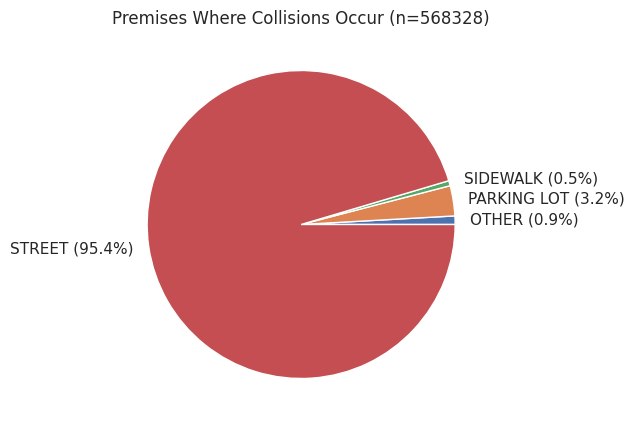

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
wedges, texts = ax.pie(premise2["counts"],
                                  labels = premise2["description3"],
                                  shadow = False)
ax.set_title("Premises Where Collisions Occur (n="+str(prem_total)+")")
plt.show()

In [38]:
dfin_p2015[["premise_code","premise_description"]].value_counts()

,,count
premise_code,premise_description,
101.0,STREET,249099
108.0,PARKING LOT,7832
102.0,SIDEWALK,1342
104.0,DRIVEWAY,470
103.0,ALLEY,448
...,...,...
251.0,RECYCLING CENTER,1
402.0,MARKET,1
403.0,DRUG STORE,1


In [39]:
dfin_2015p[["premise_code","premise_description"]].value_counts()

,,count
premise_code,premise_description,
101.0,STREET,293136
108.0,PARKING LOT,10163
102.0,SIDEWALK,1696
103.0,ALLEY,562
104.0,DRIVEWAY,505
...,...,...
411.0,PET STORE,1
416.0,THE BEVERLY CENTER,1
509.0,MOBILE HOME/TRAILERS/CONSTRUCTION TRAILERS/RV'S/MOTORHOME,1


Most of the collisions occur on streets, parking lots, and side walks in that order. This didn't change post-Vision Zero implementation.

When examining which precincts receive the most collision report, I use `rd_prec` and its corresponding description `rd_aprec`. I can plot them as a bar graph.

In [40]:
precincts = dfin[["rd_prec", "rd_aprec"]].value_counts(ascending=True).reset_index(name="counts")
precincts

,rd_prec,rd_aprec,counts
0,16.0,FOOTHILL,20020
1,4.0,HOLLENBECK,20692
2,2.0,RAMPART,21355
3,5.0,HARBOR,21373
4,1.0,CENTRAL,23354
5,21.0,TOPANGA,24201
6,18.0,SOUTHEAST,24544
7,19.0,MISSION,24780
8,11.0,NORTHEAST,25454
9,6.0,HOLLYWOOD,26832


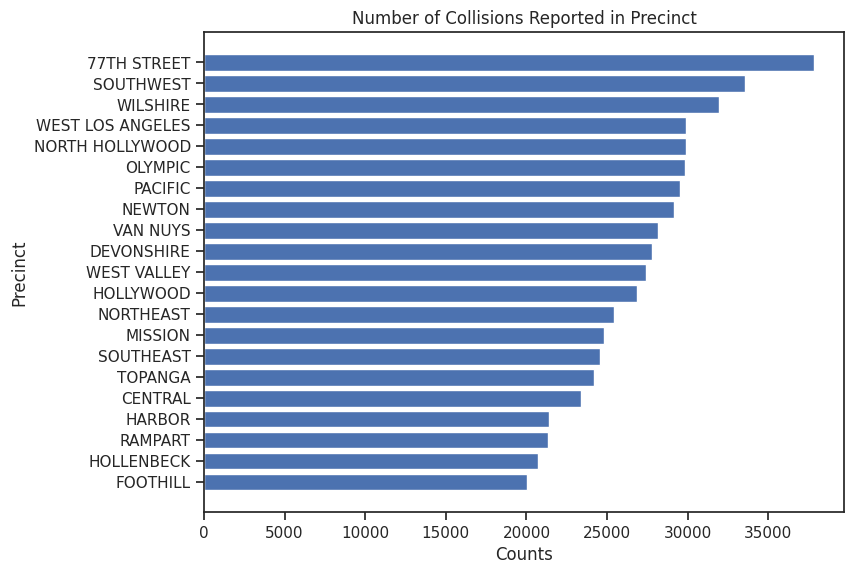

In [41]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(precincts["rd_aprec"],precincts["counts"])

ax.set_xlabel('Counts')
ax.set_ylabel('Precinct')
ax.set_title('Number of Collisions Reported in Precinct')
plt.show()

In [42]:
dfin[["rd_prec", "rd_aprec","rd_bureau"]].value_counts()

,,,count
rd_prec,rd_aprec,rd_bureau,
12.0,77TH STREET,SOUTH BUREAU,37801
3.0,SOUTHWEST,SOUTH BUREAU,33534
7.0,WILSHIRE,WEST BUREAU,31950
8.0,WEST LOS ANGELES,WEST BUREAU,29901
15.0,NORTH HOLLYWOOD,VALLEY BUREAU,29891
20.0,OLYMPIC,WEST BUREAU,29804
14.0,PACIFIC,WEST BUREAU,29499
13.0,NEWTON,CENTRAL BUREAU,29124
9.0,VAN NUYS,VALLEY BUREAU,28169


The South Bureau (given by `rd_bureau`) contains the two precincts with the highest reporting: 77th Street and Southwest.

In [43]:
precinct_p2015 = dfin_p2015[["rd_prec", "rd_aprec","rd_bureau"]].value_counts().reset_index(name="counts_p2015")
precinct_p2015

,rd_prec,rd_aprec,rd_bureau,counts_p2015
0,8.0,WEST LOS ANGELES,WEST BUREAU,15342
1,12.0,77TH STREET,SOUTH BUREAU,15300
2,3.0,SOUTHWEST,SOUTH BUREAU,15183
3,7.0,WILSHIRE,WEST BUREAU,15045
4,15.0,NORTH HOLLYWOOD,VALLEY BUREAU,14375
5,20.0,OLYMPIC,WEST BUREAU,14148
6,14.0,PACIFIC,WEST BUREAU,13898
7,9.0,VAN NUYS,VALLEY BUREAU,13196
8,10.0,WEST VALLEY,VALLEY BUREAU,12772
9,17.0,DEVONSHIRE,VALLEY BUREAU,12721


In [44]:
precinct_2015p = dfin_2015p[["rd_prec", "rd_aprec","rd_bureau"]].value_counts().reset_index(name="counts_2015p")
precinct_2015p

,rd_prec,rd_aprec,rd_bureau,counts_2015p
0,12.0,77TH STREET,SOUTH BUREAU,22501
1,3.0,SOUTHWEST,SOUTH BUREAU,18351
2,13.0,NEWTON,CENTRAL BUREAU,17187
3,7.0,WILSHIRE,WEST BUREAU,16905
4,20.0,OLYMPIC,WEST BUREAU,15656
5,14.0,PACIFIC,WEST BUREAU,15601
6,15.0,NORTH HOLLYWOOD,VALLEY BUREAU,15516
7,17.0,DEVONSHIRE,VALLEY BUREAU,15068
8,9.0,VAN NUYS,VALLEY BUREAU,14973
9,18.0,SOUTHEAST,SOUTH BUREAU,14895


In [45]:
pd.merge(precinct_p2015,precinct_2015p, on=["rd_prec","rd_aprec","rd_bureau"], how="left")

,rd_prec,rd_aprec,rd_bureau,counts_p2015,counts_2015p
0,8.0,WEST LOS ANGELES,WEST BUREAU,15342,14559
1,12.0,77TH STREET,SOUTH BUREAU,15300,22501
2,3.0,SOUTHWEST,SOUTH BUREAU,15183,18351
3,7.0,WILSHIRE,WEST BUREAU,15045,16905
4,15.0,NORTH HOLLYWOOD,VALLEY BUREAU,14375,15516
5,20.0,OLYMPIC,WEST BUREAU,14148,15656
6,14.0,PACIFIC,WEST BUREAU,13898,15601
7,9.0,VAN NUYS,VALLEY BUREAU,13196,14973
8,10.0,WEST VALLEY,VALLEY BUREAU,12772,14615
9,17.0,DEVONSHIRE,VALLEY BUREAU,12721,15068


I find that collisions increased in each precinct. This may be explained because there are 5 years of data for pre-Vision Zero and 6 years of data when Vision Zero has been implemented.

In my analysis of each of questions regarding the locations, I see that there is some change, but nothing drastic. Since this is just an analysis of the collisions, I cannot say for sure if this is solely caused by Vision Zero. Additionally, I will need to account for the change in the rate of traffic through the years which I do not have.

## MO Codes

MO Codes are labels for what each collision is associated with. It can be used to identify injuries, charges, and types of collision, so I wanted to look at whether there were a decrease in dangerous collisions once Vision Zero has started. While I can take a look at the numbers currently, I cannot attribute cause and effect without an experiment.
* Are there MO Codes that are not related to traffic collisions?
* What type of collisions were there?
* How many of the collisions had victims?

In [46]:
mo_fin.head()

,dr_number,orig_var,mo_code,code_def,mo_code_clean
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes,3036
1,190319680,mo_code_0,3037,T/C - At Intersection - No,3037
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident,0605
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident,0605


Are there MO Codes that are not related to traffic collisions?

In [47]:
mo_fin['traffic'] = mo_fin["code_def"].str.contains("Traffic|^T/C|traffic", na=False)

In [48]:
mo_fin.head()

,dr_number,orig_var,mo_code,code_def,mo_code_clean,traffic
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes,3036,True
1,190319680,mo_code_0,3037,T/C - At Intersection - No,3037,True
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101,True
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident,0605,True
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident,0605,True


In [49]:
mo_fin[mo_fin["traffic"]]["code_def"].value_counts()

,count
code_def,
T/C - PCF (A) In the Narrative,417097
T/C - Type of Collision,341234
T/C - Movement Preceding Collision,341229
T/C - Veh vs Veh,246940
T/C - At Intersection - No,223637
...,...
T/C - Train vs Bike,12
T/C - Traffic Control Devices,11
T/C - Weather/Lighting/Roadway,11


In [50]:
mo_fin[~mo_fin["traffic"]]

,dr_number,orig_var,mo_code,code_def,mo_code_clean,traffic
31,190617736,mo_code_0,0947,NaN,NaN,False
124,190615561,mo_code_0,0947,NaN,NaN,False
153,191112807,mo_code_0,1402,Evidence Booked (any crime),1402,False
192,191317613,mo_code_0,1501,Other MO (see rpt),1501,False
257,191516209,mo_code_0,1300,Vehicle involved,1300,False
...,...,...,...,...,...,...
3181693,210217754,mo_code_9,1402,Evidence Booked (any crime),1402,False
3181699,211115513,mo_code_9,0907,Narcotics (Buy-Sell-Rip),0907,False
3181881,210219050,mo_code_9,1402,Evidence Booked (any crime),1402,False
3181890,212018348,mo_code_9,0947,NaN,NaN,False


In [51]:
mo_fin[~mo_fin["traffic"]]["code_def"].value_counts().reset_index()[:20]

,code_def,count
0,Other MO (see rpt),12353
1,Vehicle involved,9128
2,Evidence Booked (any crime),3871
3,Victim was Homeless/Transient,993
4,Aid victim,963
5,Forced to masturbate suspect,951
6,Suspect is homeless/transient,314
7,Suspect intoxicated/drunk,238
8,"Public Transit (Metrolink/Train Station,Metro ...",232
9,Susp uses vehicle,217


In [52]:
dr_traffic = mo_fin[mo_fin["traffic"]]["dr_number"].unique()
mo_fin[~mo_fin["dr_number"].isin(dr_traffic)]["dr_number"].value_counts()

,count
dr_number,
121810924,10
181608443,10
201800713,10
171500596,10
211421265,9
...,...
101817636,1
101816009,1
101906296,1


In [53]:
mo_fin[~mo_fin["dr_number"].isin(dr_traffic)]["code_def"].value_counts()

,count
code_def,
Other MO (see rpt),5083
Evidence Booked (any crime),1360
Vehicle involved,919
Forced to masturbate suspect,891
Narcotics (Buy-Sell-Rip),112
...,...
Sprayed with chemical,1
Teach,1
Demands money,1


After I created a variable for whether a traffic accident was coded, I find that there were still several codes. These codes seem to involve multiple people, and there are 8,511 records which did not have a MO Code associated with a traffic collision. Most of these were an "other" MO code or another crime was associated with them.

When I seek to answer what type of collisions there were, I have to look at the ones where the code definition include "vs." This is from a quick glance at the code descriptions when the `traffic` variable indicated it was a traffic collision.

In [54]:
mo_fin.loc[:, "vs"] = mo_fin["code_def"].str.contains(" vs ", na=False)
mo_fin[mo_fin["vs"]]["code_def"].value_counts()

,count
code_def,
T/C - Veh vs Veh,246940
T/C - Veh vs Parked Veh,107626
T/C - Veh vs Ped,31497
T/C - Veh vs Fixed Object,31264
T/C - Veh vs Bike,18080
T/C - Veh vs M/C,7085
T/C - Bike vs Veh,1410
T/C - Veh vs Other Object,1369
T/C - M/C vs Veh,532


Most of the collisions were between vehicles and other vehicles. I then combined wanted to see if there were certain collisions that had more victims than others, as well as compare if anything has changed since Vision Zero has been implemented.

In [55]:
victim_dttm = dfin[["dr_number", "victim","dttm_occurred"]]
mo_fin_vict = pd.merge(mo_fin,
                       victim_dttm,
                       on = "dr_number",
                       how = "left")
mo_fin_vict

,dr_number,orig_var,mo_code,code_def,mo_code_clean,traffic,vs,victim,dttm_occurred
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes,3036,True,False,True,2019-08-24 04:50:00
1,190319680,mo_code_0,3037,T/C - At Intersection - No,3037,True,False,True,2019-08-30 23:20:00
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101,True,False,True,2019-08-25 05:45:00
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident,0605,True,False,True,2019-11-20 03:50:00
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident,0605,True,False,True,2019-08-30 21:00:00
...,...,...,...,...,...,...,...,...,...
3160705,181616582,mo_code_9,3602,T/C - Unlicensed motorist,3602,True,False,True,2018-11-15 13:45:00
3160706,191917533,mo_code_9,4026,T/C - Valley Traffic (VTD),4026,True,False,True,2019-10-05 19:30:00
3160707,191917534,mo_code_9,3401,T/C - Type of Collision,3401,True,False,True,2019-10-05 19:35:00
3160708,211321028,mo_code_9,3401,T/C - Type of Collision,3401,True,False,True,2021-12-29 19:10:00


In [56]:
code_victs = mo_fin_vict[mo_fin_vict["vs"]][["code_def","victim"]].value_counts().sort_index()\
    .reset_index(name="NumRecords")
code_victs

,code_def,victim,NumRecords
0,T/C - Bike vs Other,False,1
1,T/C - Bike vs Other,True,286
2,T/C - Bike vs Train,True,8
3,T/C - Bike vs Veh,False,1
4,T/C - Bike vs Veh,True,1409
5,T/C - M/C vs Fixed Object,False,5
6,T/C - M/C vs Fixed Object,True,330
7,T/C - M/C vs Other,False,4
8,T/C - M/C vs Other,True,365
9,T/C - M/C vs Veh,False,5


In [57]:
code_victs_wide = pd.pivot(code_victs, index = "code_def", columns="victim", values="NumRecords").reset_index()

code_victs_wide.rename(columns={False:"Falses",True:"Trues"},inplace=True)

code_victs_wide["ranked"] = code_victs_wide["Trues"].rank()

code_victs_wide.set_index("ranked", inplace=True)

code_victs_wide = code_victs_wide.sort_index()
code_victs_wide

victim,code_def,Falses,Trues
ranked,,,
1.0,T/C - Bike vs Train,NaN,8.0
2.0,T/C - Train vs Bike,NaN,12.0
3.0,T/C - Train vs Train,2.0,22.0
4.5,T/C - Train vs Veh,1.0,27.0
4.5,T/C - Train vs Fixed Object,NaN,27.0
6.0,T/C - Train vs Ped,3.0,75.0
7.0,T/C - Veh vs Train,NaN,154.0
8.0,T/C - Veh vs Animal,NaN,248.0
9.0,T/C - Bike vs Other,1.0,286.0


In [58]:
code_victs_wide.fillna(0,inplace=True)

code_victs_wide["code_def"] = code_victs_wide["code_def"].str.replace("T/C - ","")
code_victs_wide["code_def"] = code_victs_wide["code_def"].str.replace("M/C","Motorcycle")
code_victs_wide["code_def"] = code_victs_wide["code_def"].str.replace("Veh","Vehicle")
code_victs_wide["code_def"] = code_victs_wide["code_def"].str.replace("Ped","Pedestrian")
code_victs_wide

victim,code_def,Falses,Trues
ranked,,,
1.0,Bike vs Train,0.0,8.0
2.0,Train vs Bike,0.0,12.0
3.0,Train vs Train,2.0,22.0
4.5,Train vs Vehicle,1.0,27.0
4.5,Train vs Fixed Object,0.0,27.0
6.0,Train vs Pedestrian,3.0,75.0
7.0,Vehicle vs Train,0.0,154.0
8.0,Vehicle vs Animal,0.0,248.0
9.0,Bike vs Other,1.0,286.0


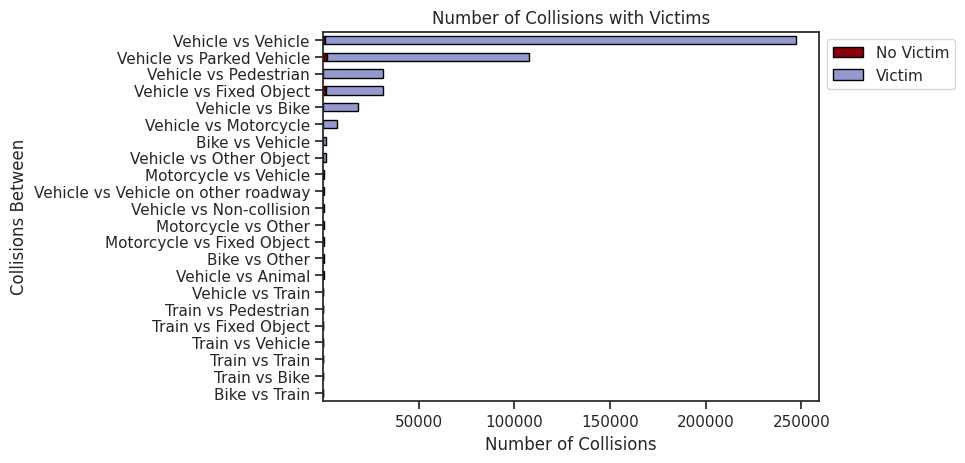

In [59]:
code_victs_wide.plot(kind='barh',
                     stacked=True,
                     title="Number of Collisions with Victims",
                     color = ["#880009","#949ad0"],
                     x = "code_def",
                     edgecolor="black")
plt.legend(['No Victim', 'Victim'], bbox_to_anchor =(1,1,0,0), ncol = 1)
plt.ylabel("Collisions Between")
plt.xlabel("Number of Collisions")
plt.show()

In [60]:
vs = mo_fin_vict[mo_fin_vict["vs"]][["dr_number"]].value_counts().reset_index(name="NumVS")
vs

,dr_number,NumVS
0,131425177,3
1,130709998,3
2,140708388,3
3,141214905,3
4,190320349,3
...,...,...
446896,151104681,1
446897,151104670,1
446898,151104649,1
446899,151104641,1


In [61]:
vs["NumVS"].value_counts()

,count
NumVS,
1,445571
2,1302
3,28


In [62]:
mo_fin_vict_p2015 = mo_fin_vict[mo_fin_vict["dr_number"].isin(dfin_p2015["dr_number"])]
mo_fin_vict_2015p = mo_fin_vict[mo_fin_vict["dr_number"].isin(dfin_2015p["dr_number"])]

In [63]:
mult_p2015 = mo_fin_vict_p2015[mo_fin_vict_p2015["vs"]][["dr_number"]].value_counts().reset_index(name="NumVS")
print(mult_p2015["NumVS"].value_counts())
print("")
print(mult_p2015["NumVS"].value_counts(normalize=True))

NumVS
1    156752
2       431
3        15
Name: count, dtype: int64

NumVS
1    0.997163
2    0.002742
3    0.000095
Name: proportion, dtype: float64


In [64]:
mult_2015p = mo_fin_vict_2015p[mo_fin_vict_2015p["vs"]][["dr_number"]].value_counts().reset_index(name="NumVS")
print(mult_2015p["NumVS"].value_counts())
print("")
print(mult_2015p["NumVS"].value_counts(normalize=True))

NumVS
1    288819
2       871
3        13
Name: count, dtype: int64

NumVS
1    0.996949
2    0.003007
3    0.000045
Name: proportion, dtype: float64


When I look at the MO Codes that indicated the collisions were between things, I find that most of the collisions had a victim associated with them. The overwhelming majority of the collisions with a "vs" associated with them only had collisions between one thing (445,571), but 1,302 had two objects, and 28 had three objects.

I can compare what it was like pre-Vision Zero and when it has been implemented. Based on raw counts, there were more in general, especially between one and two additional objects; however, when I compare the percentages, it stayed about the same. Thus, I decided to examine whether there were changes in injuries.

In [65]:
mo_fin_vict.loc[:,"injury"] = mo_fin_vict["code_def"].str.contains("Injury|injury", na=False)
mo_fin_vict[mo_fin_vict["injury"]]["code_def"].value_counts()

,count
code_def,
T/C - (N) Non Injury,157995
T/C - (C) Complaint of Injury,136676
T/C - (B) Visible Injury,61982
T/C - (A) Severe Injury,11449
T/C - (K) Fatal Injury,2345


In [66]:
injuries = mo_fin_vict[mo_fin_vict["injury"]]
injuries["code_def"] = injuries["code_def"].str[10:]
injuries

<ipython-input-66-a872add5c81f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dr_number,orig_var,mo_code,code_def,mo_code_clean,traffic,vs,victim,dttm_occurred,injury
38,190617818,mo_code_0,3026,Complaint of Injury,3026,True,False,True,2019-08-22 15:50:00,True
55,190618126,mo_code_0,3028,Non Injury,3028,True,False,True,2019-08-27 17:45:00,True
76,190715905,mo_code_0,3028,Non Injury,3028,True,False,True,2019-08-29 07:10:00,True
108,190814692,mo_code_0,3026,Complaint of Injury,3026,True,False,True,2019-08-26 07:40:00,True
115,190814763,mo_code_0,3025,Visible Injury,3025,True,False,True,2019-08-24 10:40:00,True
...,...,...,...,...,...,...,...,...,...,...
3160545,210415614,mo_code_9,3028,Non Injury,3028,True,False,True,2021-12-06 18:20:00,True
3160570,211320032,mo_code_9,3027,Fatal Injury,3027,True,False,True,2020-10-21 23:15:00,True
3160573,210122121,mo_code_9,3026,Complaint of Injury,3026,True,False,True,2021-12-14 04:20:00,True
3160591,210122255,mo_code_9,3028,Non Injury,3028,True,False,True,2021-12-15 23:00:00,True


In [67]:
injuries["dr_number"].value_counts()

,count
dr_number,
201814666,3
151206702,3
201813339,3
200504224,3
170417500,3
...,...
180713103,1
180709382,1
180714529,1


In [68]:
numinjury = injuries.groupby("dr_number").agg("count").reset_index()

numinjury["injury"].value_counts()

,count
injury,
1,368838
2,794
3,7


In [69]:
injuries_p2015 = injuries[injuries["dr_number"].isin(dfin_p2015["dr_number"])]
injuries_2015p = injuries[injuries["dr_number"].isin(dfin_2015p["dr_number"])]

In [70]:
print(injuries_p2015["code_def"].value_counts())
print("")
print(injuries_p2015["code_def"].value_counts(normalize=True))

code_def
Complaint of Injury    47536
Non Injury             36673
Visible Injury         23260
Severe Injury           3434
Fatal Injury             739
Name: count, dtype: int64

code_def
Complaint of Injury    0.425790
Non Injury             0.328487
Visible Injury         0.208345
Severe Injury          0.030759
Fatal Injury           0.006619
Name: proportion, dtype: float64


In [71]:
print(injuries_2015p["code_def"].value_counts())
print("")
print(injuries_2015p["code_def"].value_counts(normalize=True))

code_def
Non Injury             121322
Complaint of Injury     89140
Visible Injury          38722
Severe Injury            8015
Fatal Injury             1606
Name: count, dtype: int64

code_def
Non Injury             0.468778
Complaint of Injury    0.344429
Visible Injury         0.149618
Severe Injury          0.030969
Fatal Injury           0.006205
Name: proportion, dtype: float64


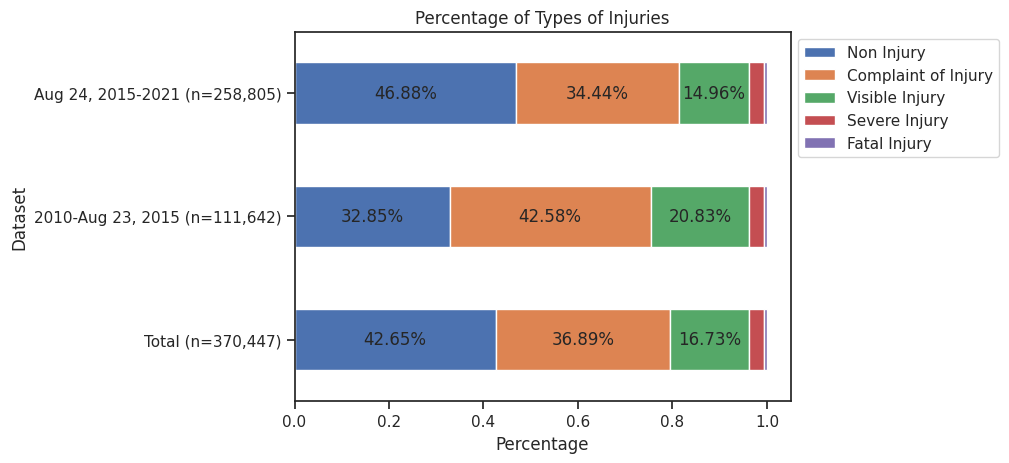

In [72]:
inj_cnt_tot = injuries["code_def"].value_counts().sum()
inj_cnt_p2015 = injuries_p2015["code_def"].value_counts().sum()
inj_cnt_2015p = injuries_2015p["code_def"].value_counts().sum()

inj_total = injuries["code_def"].value_counts(normalize=True).reset_index(name="Total")
inj_p2015 = injuries_p2015["code_def"].value_counts(normalize=True).reset_index(name="Pre-VisionZero")
inj_2015p = injuries_2015p["code_def"].value_counts(normalize=True).reset_index(name="Post-VisionZero")

tot_p2015 = pd.merge(inj_total,
                     inj_p2015,
                     on="code_def",
                     how="left")

tot_p2015_2015p = pd.merge(tot_p2015,
                          inj_2015p,
                           on="code_def",
                           how="left")
tot_p2015_2015p

inj_pct = tot_p2015_2015p.loc[:,["code_def","Total","Pre-VisionZero","Post-VisionZero"]]
inj_pct
inj_pct_t = inj_pct.T
inj_pct_t.columns = inj_pct_t.iloc[0]
inj_pct_t.drop(index="code_def", inplace=True)
# inj_pct_t = inj_pct_t.reindex(["Total","Pre-VisionZero","Post-VisionZero"]) # no longer necessary
inj_pct_t

inj_pct_t.loc["Post-VisionZero","new_index"] = "Aug 24, 2015-2021"+" (n="+"{:,}".format(inj_cnt_2015p)+")"
inj_pct_t.loc["Pre-VisionZero","new_index"] = "2010-Aug 23, 2015"+" (n="+"{:,}".format(inj_cnt_p2015)+")"
inj_pct_t.loc["Total","new_index"] = "Total"+" (n="+"{:,}".format(inj_cnt_tot)+")"
inj_pct_t.set_index("new_index",inplace=True)

ax = inj_pct_t.plot(kind="barh", stacked=True)
plt.title("Percentage of Types of Injuries")
plt.xlabel("Percentage")
plt.ylabel("Dataset")
plt.legend(bbox_to_anchor=(1,1,0,0))

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    if width >= 0.05:
        label_text = "{:.2%}".format(width)
    else:
        label_text = ""
    label_x = x + width/2
    label_y = y + height/2
    ax.text(label_x, label_y, label_text, ha="center",va="center")

plt.show()

Most of the incidents did not contain injuries, but when there injuries, most of the reports had a victim associated with them. There were less injuries the more severe they were. There are some incidents where there were multiple injuries (801).

When I look at whether there were any impact of Vision Zero, I see that the percentage of non-injuries increased whereas the complaint of injury and visible injuries have decreased. This is a positive improvement overall even though there are similar proportions of severe and fatal injuries.

## Regression Discontinuity

In order to analyze whether Vision Zero had any causal impact on the number of collisions, I can use a regression discontinuity design. By comparing the slopes of the number of collisions between the time frame prior to and after Vision Zero's implementation, I can detect whether there were statistically significant changes. This is possible under the assumption that August 24, 2015 is just like any other day and that there would be no difference if it were signed on January 12, March 9, August 23, or December 30; the only difference between August 23, August 24, and August 25, 2015 was just that Vision Zero was signed.

I first examine if there are any sharp changes in the number of collisions throughout the days while paying special attention to the time immediately before and after Vision Zero was signed.

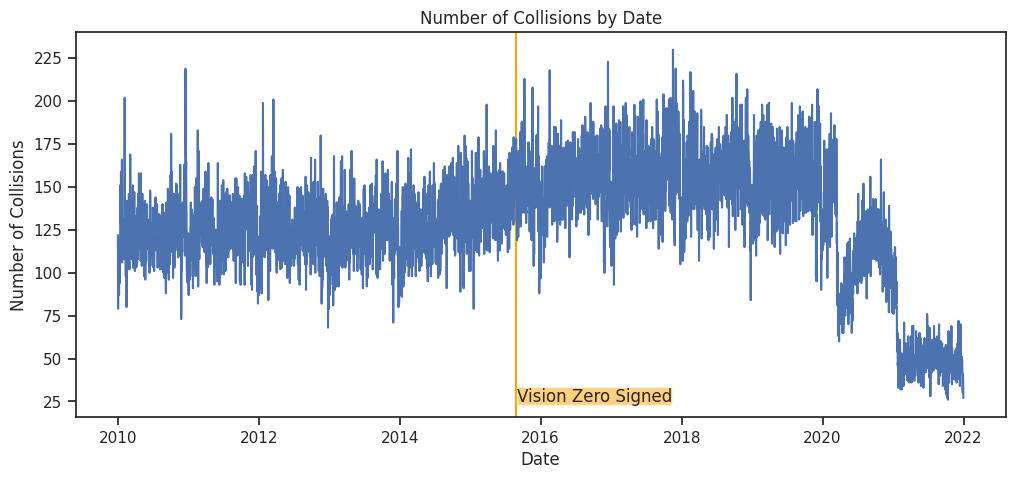

In [73]:
col_date = pd.DataFrame(dfin['dttm_occurred'].dt.date.value_counts().sort_index())

col_fig = plt.figure(figsize=(12,5))

plt.axvline(pd.to_datetime("2015-08-24"), color="orange")
plt.annotate("Vision Zero Signed", (pd.to_datetime("2015-08-30"),25),
             bbox=dict(boxstyle="square", fc="orange", alpha=0.5, pad=0))

plt.plot(col_date)
plt.xlabel("Date")
plt.ylabel("Number of Collisions")
plt.title('Number of Collisions by Date')
plt.show()

Just by eyeballing it, it does not appear as if there are any sharp changes immediately after Vision Zero was signed, but there is a sharp decrease in the number of collisions during 2020. This is likely due to the Covid-19 Pandemic and I explore more of this later on.

Even if there aren't any changes in the number of collisions (immediately prior and after Vision Zero was signed) that are apparent to me, it may be visible statistically. I use the `rdrobust` package because it uses robust standard errors with a regression discontinuity design. I first recode the number datetime column for when the collision occurred to be the number of days before or after Vision Zero was signed so the function knows which two time frames to compare.

In [74]:
# create a column which is number of days pre-post vision zero.

dfin.loc[:,"pre_post_vision_zero"] = dfin["dttm_occurred"].dt.date-datetime.date(2015,8,24)
dfin.pre_post_vision_zero.value_counts()

<ipython-input-74-3f0c811a2e42>:4: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`


,count
pre_post_vision_zero,
816 days,230
479 days,223
-1711 days,219
830 days,219
177 days,218
...,...
2233 days,29
2150 days,28
2239 days,27


In [75]:
dfin[dfin.pre_post_vision_zero==pd.Timedelta(-1, unit='d')].date_occurred.value_counts() # 8/23/2015 is correct
dfin[dfin.pre_post_vision_zero==pd.Timedelta(0, unit='d')].date_occurred.value_counts() # 8/24/2015 is correct
dfin[dfin.pre_post_vision_zero==pd.Timedelta(1, unit='d')].date_occurred.value_counts() # 8/25/2015 is correct
dfin[dfin.pre_post_vision_zero==pd.Timedelta(816, unit='d')].date_occurred.value_counts() # 230 is the correct count for 816 days

,count
date_occurred,
11/17/2017,230


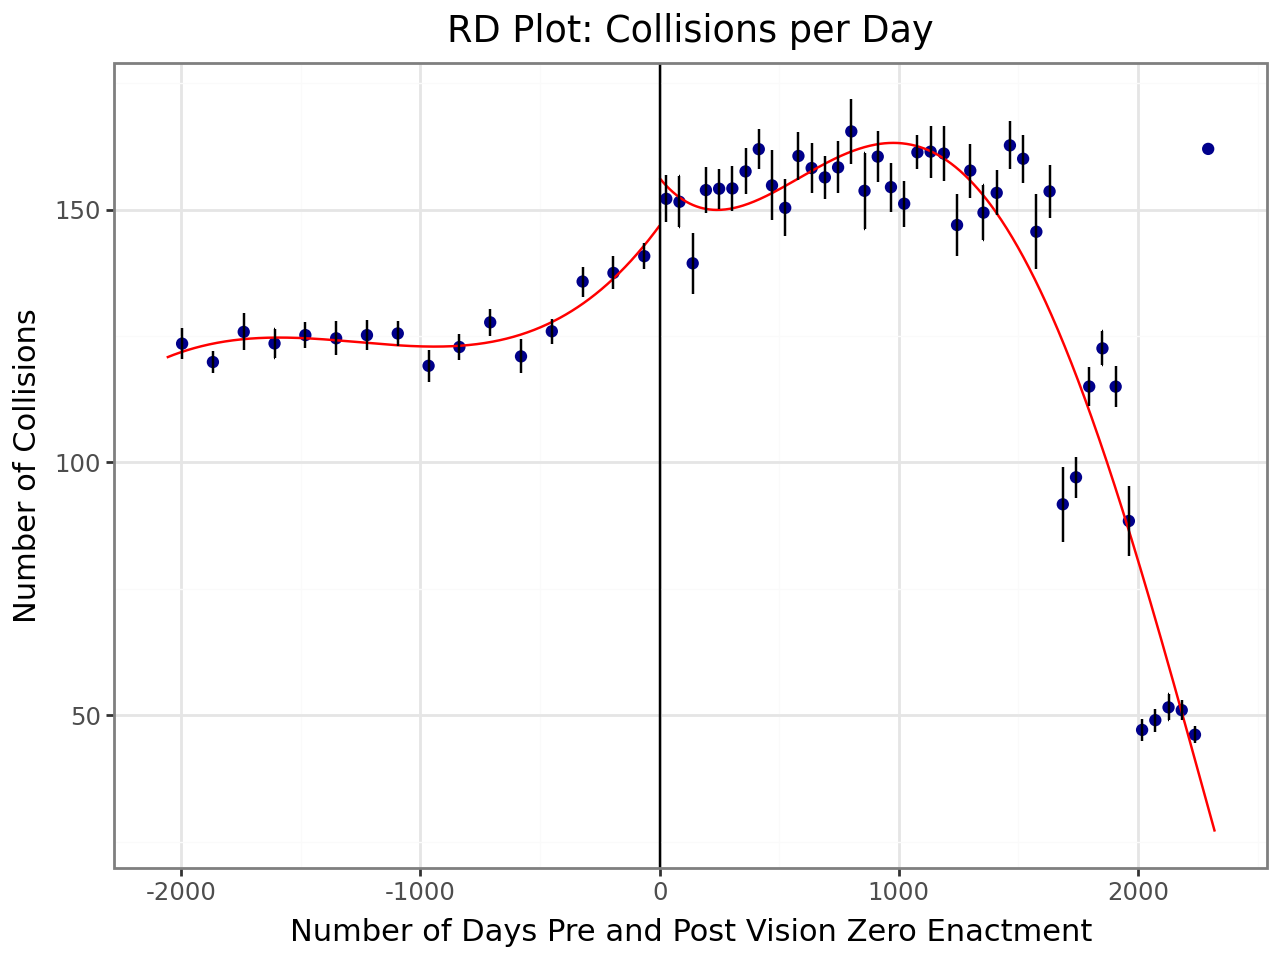

Call: rdplot
Number of Observations:                  4383
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          2061       2322
Number of Effective Obs         2061       2322
Bandwith poly. fit (h)          2061       2321
Number of bins scale               1          1
Bins Selected                     16         42
Average Bin Length           128.812     55.262
Median Bin Length            128.812     55.262
IMSE-optimal bins               16.0       42.0
Mimicking Variance bins         94.0      516.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [76]:
number_collisions = dfin.groupby(["pre_post_vision_zero"])["dr_number"].count().reset_index(name='Collisions')
number_collisions

# y = number of collisions
# x = num of days pre-post Vision Zero

num_collisions = number_collisions["Collisions"]
days_coll = number_collisions.pre_post_vision_zero.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions, x=days_coll, binselect="es", ci=95,
         title="RD Plot: Collisions per Day",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Vision Zero Enactment")

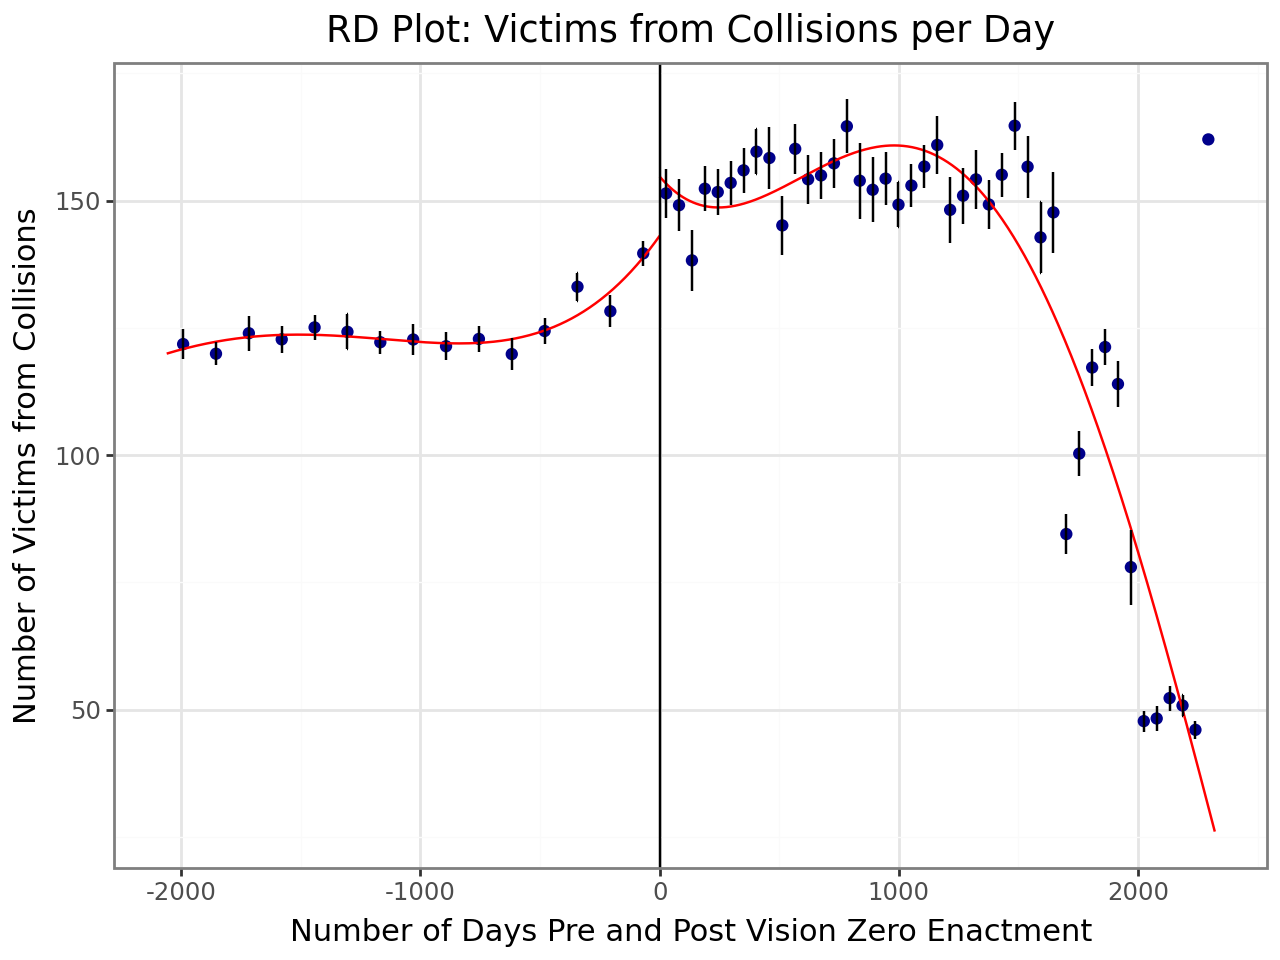

Call: rdplot
Number of Observations:                  4383
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          2061       2322
Number of Effective Obs         2061       2322
Bandwith poly. fit (h)          2061       2321
Number of bins scale               1          1
Bins Selected                     15         43
Average Bin Length             137.4     53.977
Median Bin Length              137.4     53.977
IMSE-optimal bins               15.0       43.0
Mimicking Variance bins         92.0      507.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [77]:
number_victims = pd.DataFrame(dfin.groupby(["pre_post_vision_zero"])["victim"].sum()).reset_index()
number_victims

# y = number of victims
# x = num of days pre-post Vision Zero

num_victims = number_victims["victim"]
days_vic = number_victims.pre_post_vision_zero.dt.days

# # ### rdplot with 95% confidence intervals
rdplot(y=num_victims, x=days_vic, binselect="es", ci=95,
         title="RD Plot: Victims from Collisions per Day",
         y_label="Number of Victims from Collisions",
         x_label="Number of Days Pre and Post Vision Zero Enactment")

In [78]:
### rdrobust
print(rdrobust(y=num_victims, x=days_vic))

Call: rdrobust
Number of Observations:                  4383
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          2061       2322
Number of Unique Obs.           2061       2322
Number of Effective Obs.         436        437
Bandwidth Estimation         436.192    436.192
Bandwidth Bias               810.884    810.884
rho (h/b)                      0.538      0.538

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       6.028    2.101    2.869   4.115e-03     [1.91, 10.146]
Robust                 -        -    2.179   2.931e-02     [0.519, 9.791]



In [79]:
### rdrobust with all estimates
print(rdrobust(y=num_victims, x=days_vic, all=True))

Call: rdrobust
Number of Observations:                  4383
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          2061       2322
Number of Unique Obs.           2061       2322
Number of Effective Obs.         436        437
Bandwidth Estimation         436.192    436.192
Bandwidth Bias               810.884    810.884
rho (h/b)                      0.538      0.538

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       6.028    2.101    2.869   4.115e-03     [1.91, 10.146]
Bias-Corrected     5.155    2.101    2.454   1.414e-02     [1.037, 9.273]
Robust             5.155    2

Judging by the graphs and the significance tests, there is a difference between the number of collisions before and after Vision Zero was signed, but the number of collisions actually increased. Even when we filter for whether there is a victim, the story remains similar.

The next step is to isolate the effects of the pandemic.

*Note*

I'm leaving these two blocks of the analysis here because I might come back to this in the future. The [documentation](https://github.com/rdpackages/rdrobust/tree/master/Python/rdrobust) for the `rdrobust` package is sparse at the time of writing, and I mostly followed the code that is shown in the example. This may be an instance where math is just numbers and the code works, but the meaning is incomprehensible (i.e., 1+2=3, but 1 apple + 2 miles = 3 apples and miles makes no sense)

Block 1: I'm not sure what the "backwards compatability" meant, why the variables for `h` and `b` are hard-coded, or where the hard-coded numbers come from.

Block 2: What is t+2 and how was that calculated? I've kept it here, but I'll need to dive deeper into the code and statistics.

In [80]:
# Block 1
## double-check this
## rdrobust backward compatibility
print(rdrobust(y=num_victims, x=days_vic, h=16.79369, b=27.43745))

Call: rdrobust
Number of Observations:                  4383
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   Manual
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          2061       2322
Number of Unique Obs.           2061       2322
Number of Effective Obs.          16         17
Bandwidth Estimation          16.794     16.794
Bandwidth Bias                27.437     27.437
rho (h/b)                      0.612      0.612

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       2.493    8.277    0.301   7.632e-01  [-13.729, 18.716]
Robust                 -        -    0.572   5.675e-01  [-13.853, 25.264]



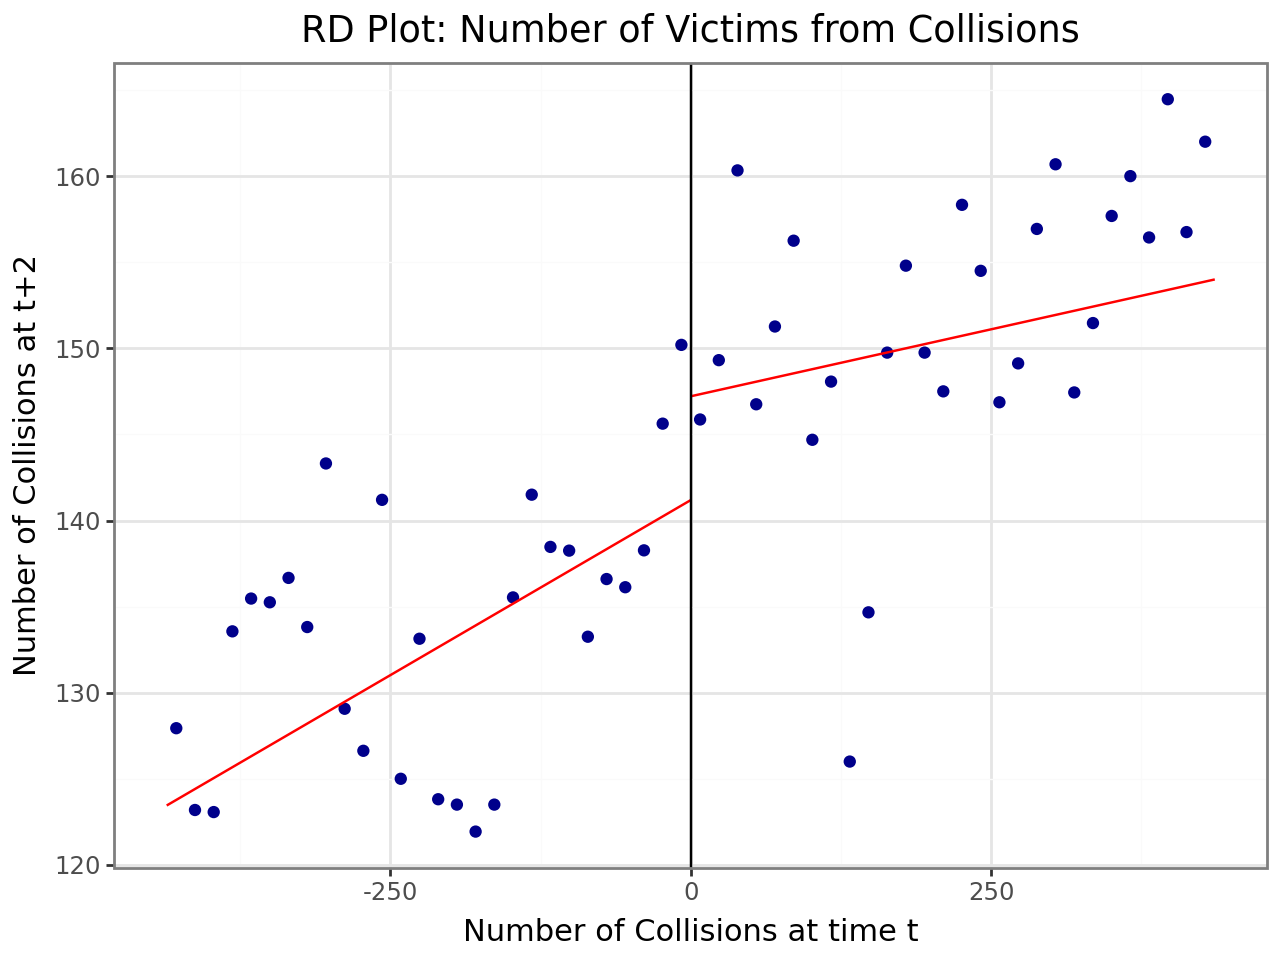

Call: rdplot
Number of Observations:                   873
Kernel:                            Triangular
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations           436        437
Number of Effective Obs          436        437
Bandwith poly. fit (h)       436.192    436.192
Number of bins scale               1          1
Bins Selected                     28         28
Average Bin Length            15.571     15.571
Median Bin Length             15.571     15.571
IMSE-optimal bins               11.0        6.0
Mimicking Variance bins         28.0       28.0

Relative to IMSE-optimal:
Implied scale                  2.545      4.667
WIMSE variance weight          0.057       0.01
WIMSE bias weight              0.943       0.99


In [81]:
# Block 2
#### double-check this
## rdplot to show rdrobust estimate
est = rdrobust(y=num_victims, x=days_vic)
h_l, h_r = est.bws.loc['h', :].values
subset = ((-h_l<= days_vic) & (days_vic <= h_r)).values

rdplot(y=num_victims, x=days_vic, subset=subset,
       binselect="esmv", kernel="triangular", h=[h_l,h_r], p=1,
       title="RD Plot: Number of Victims from Collisions",
       y_label="Number of Collisions at t+2",
       x_label="Number of Collisions at time t")

### Pandemic

On March 11, 2020, the World Health Organization declared Covid-19 a pandemic. This marked a shift in policy across the world, and people were less willing to venture outside and, in some cases, lockdowns. For this analysis, I try to disentangle the effects of the pandemic from the number of collisions due to the fact that less cars on the road mean less collisions, and less people on the road means less victims.

First, I filter for the days before the pandemic was declared.

In [82]:
dfin.loc[:,"postcovid"] = dfin["dttm_occurred"].dt.date-datetime.date(2020,3,11)
dfin["postcovid"].value_counts()

dfin[dfin.postcovid==pd.Timedelta(-1, unit='d')].date_occurred.value_counts() # 3/10/2020 is correct
dfin[dfin.postcovid==pd.Timedelta(0, unit='d')].date_occurred.value_counts() # 3/11/2020 is correct
dfin[dfin.postcovid==pd.Timedelta(1, unit='d')].date_occurred.value_counts() #3/12/2020 is correct

<ipython-input-82-bd4dae83ae48>:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`


,count
date_occurred,
03/12/2020,134


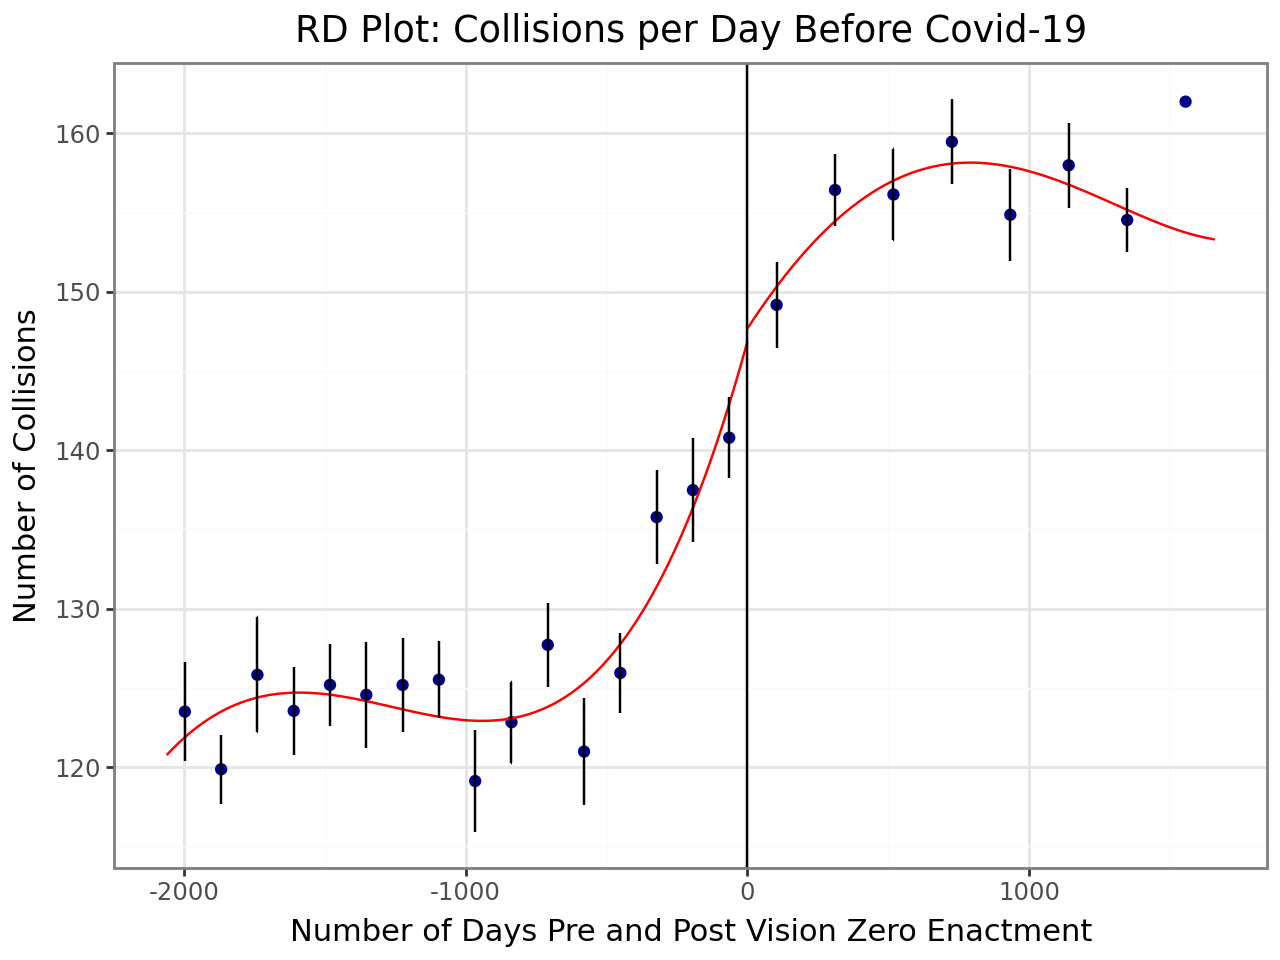

Call: rdrobust
Number of Observations:                  3721
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          2061       1660
Number of Unique Obs.           2061       1660
Number of Effective Obs.         476        477
Bandwidth Estimation         476.613    476.613
Bandwidth Bias               742.591    742.591
rho (h/b)                      0.642      0.642

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       3.955    2.045    1.935   5.303e-02    [-0.052, 7.963]
Bias-Corrected      3.58    2.045    1.751   7.991e-02    [-0.427, 7.588]
Robust              3.58    2

In [83]:
number_collisions_nocovid = dfin[dfin["postcovid"] < pd.Timedelta(-1, unit='d')].groupby(["pre_post_vision_zero"])["dr_number"].count().reset_index(name='Collisions')
# number_collisions_nocovid.dttm_occurred.max() ## confirmed 2020-03-10 23:30:00

# y = number of collisions
# x = num of days pre-post Vision Zero

num_collisions_nocovid = number_collisions_nocovid["Collisions"]
days_coll_nocovid = number_collisions_nocovid.pre_post_vision_zero.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions_nocovid, x=days_coll_nocovid, binselect="es", ci=95,
         title="RD Plot: Collisions per Day Before Covid-19",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Vision Zero Enactment")

### rdrobust with all estimates
print(rdrobust(y=num_collisions_nocovid, x=days_coll_nocovid, all=True))

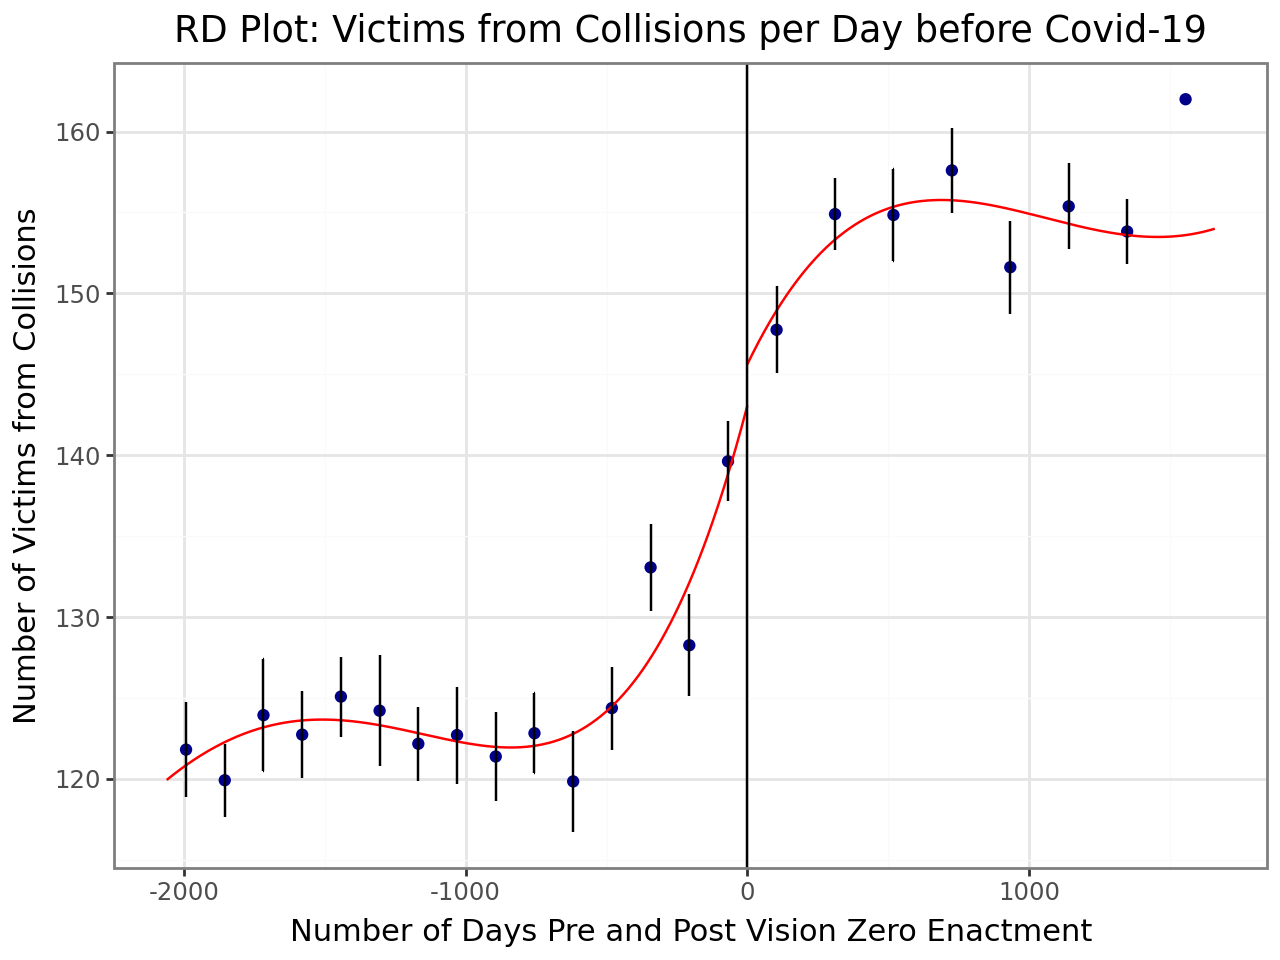

Call: rdrobust
Number of Observations:                  3721
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          2061       1660
Number of Unique Obs.           2061       1660
Number of Effective Obs.         410        411
Bandwidth Estimation         410.638    410.638
Bandwidth Bias               646.519    646.519
rho (h/b)                      0.635      0.635

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       6.011    2.158    2.786   5.339e-03    [1.782, 10.241]
Bias-Corrected     5.589    2.158     2.59   9.594e-03      [1.36, 9.818]
Robust             5.589    2

In [84]:
number_victims_nocovid = pd.DataFrame(dfin[dfin["postcovid"] < pd.Timedelta(-1, unit='d')].groupby(["pre_post_vision_zero"])["victim"].sum()).reset_index()
number_victims_nocovid
# number_victims_nocovid.pre_post_vision_zero.max() ## confirmed 1660 days
# dfin[dfin["postcovid"]].pre_post_vision_zero.min() # confirmed 1661 days

# y = number of victims
# x = num of days pre-post Vision Zero

num_victims_nocovid = number_victims_nocovid["victim"]
days_vic_nocovid = number_victims_nocovid.pre_post_vision_zero.dt.days

### rdplot with 95% confidence intervals
rdplot(y=num_victims_nocovid, x=days_vic_nocovid, binselect="es", ci=95,
         title="RD Plot: Victims from Collisions per Day before Covid-19",
         y_label="Number of Victims from Collisions",
         x_label="Number of Days Pre and Post Vision Zero Enactment")

### rdrobust with all estimates
print(rdrobust(y=num_victims_nocovid, x=days_vic_nocovid, all=True))

This shows very clearly that there is a trend that the number of collisions and victims increased after Vision Zero was signed. While the number of collisions before and after signing Vision Zero was not statistically different, there was statistical significance found when the looking at the number of victims.

However, we can also take a look at whether the pandemic had any effect on the number of collisions. The pandemic lowered the number of cars on the road due to the increased reluctance to travel, work from home orders, and lockdowns.

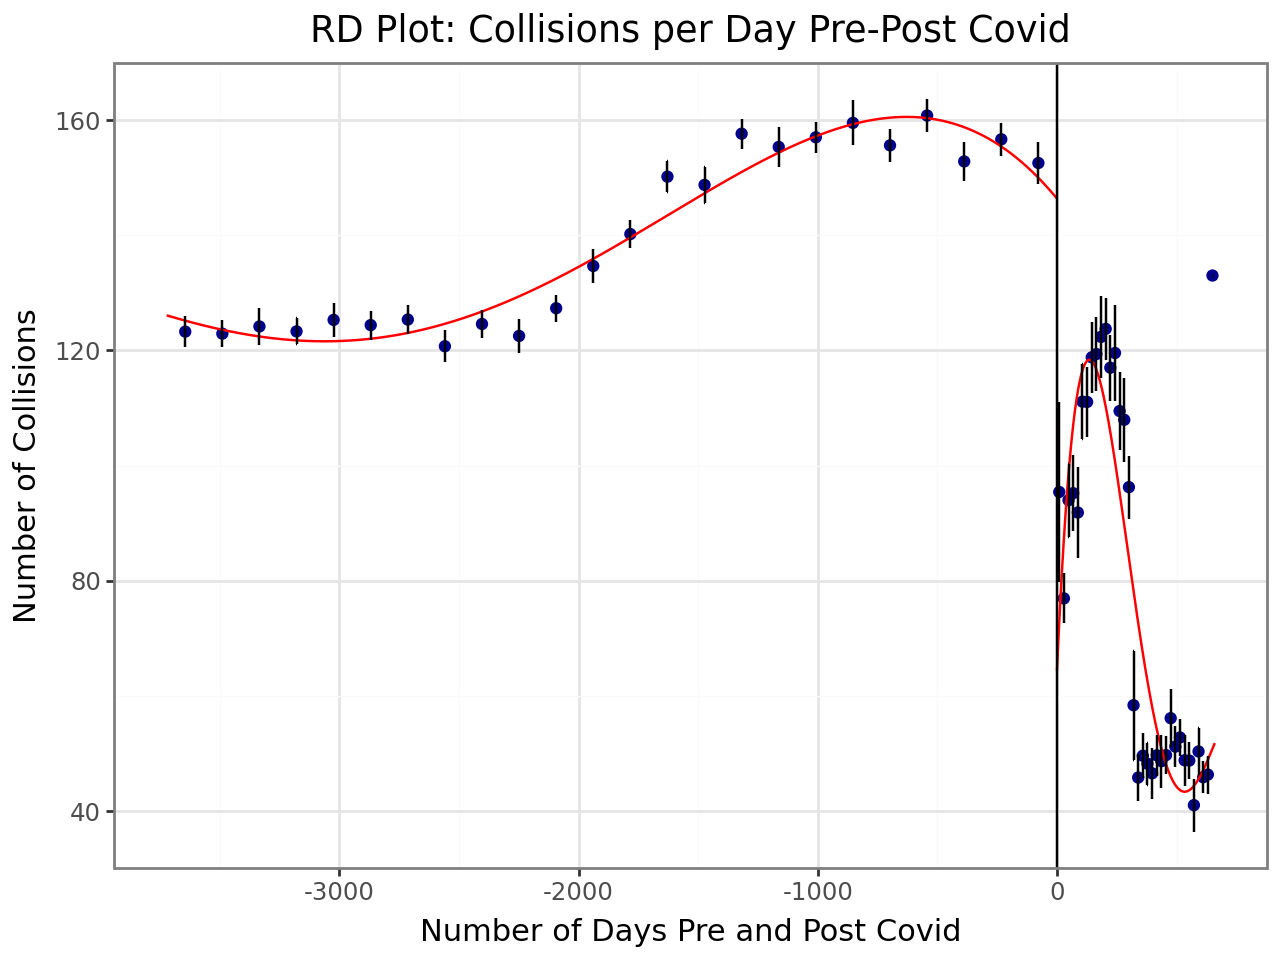

Call: rdrobust
Number of Observations:                  4383
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          3722        661
Number of Unique Obs.           3722        661
Number of Effective Obs.         109        110
Bandwidth Estimation         109.128    109.128
Bandwidth Bias               169.188    169.188
rho (h/b)                      0.645      0.645

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional     -68.128    4.746  -14.355   9.889e-47 [-77.429, -58.826]
Bias-Corrected   -68.202    4.746  -14.371   7.897e-47   [-77.503, -58.9]
Robust           -68.202    5

In [85]:
### instead of testing effectiveness of vision zero, test effect of pandemic
covid_effects = dfin.groupby(["postcovid"])["dr_number"].count().reset_index(name='Collisions')
covid_effects

# y = number of collisions
# x = num of days pre-post Covid Declaration

num_collisions_covid = covid_effects["Collisions"]
days_coll_covid = covid_effects.postcovid.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions_covid, x=days_coll_covid, binselect="es", ci=95,
         title="RD Plot: Collisions per Day Pre-Post Covid",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Covid")

### rdrobust with all estimates
print(rdrobust(y=num_collisions_covid, x=days_coll_covid, all=True))

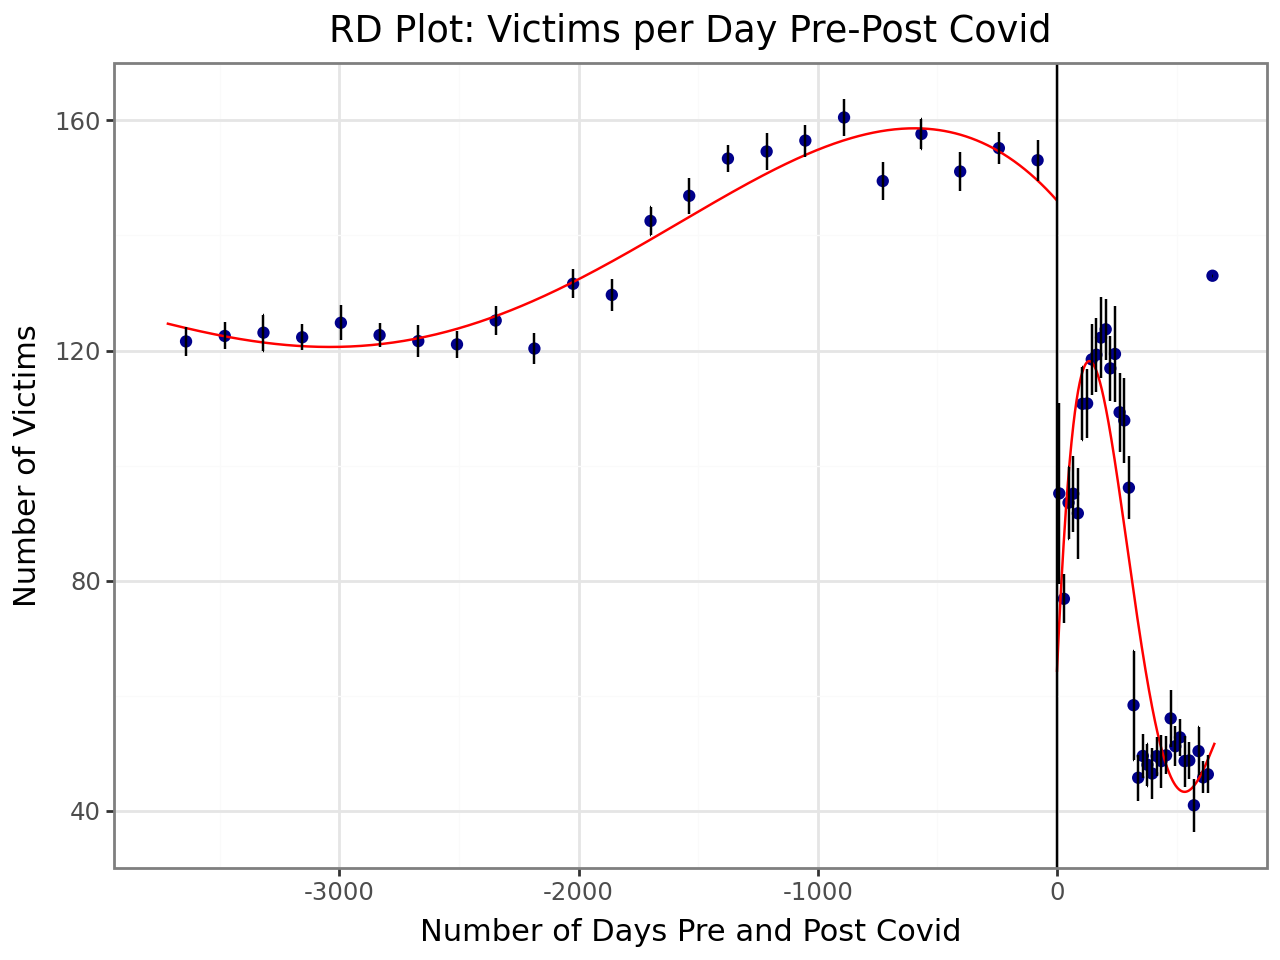

Call: rdrobust
Number of Observations:                  4383
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          3722        661
Number of Unique Obs.           3722        661
Number of Effective Obs.         109        110
Bandwidth Estimation         109.719    109.719
Bandwidth Bias               170.018    170.018
rho (h/b)                      0.645      0.645

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional     -68.213    4.722  -14.445   2.701e-47 [-77.468, -58.957]
Bias-Corrected    -68.34    4.722  -14.472   1.825e-47 [-77.596, -59.085]
Robust            -68.34    5

In [86]:
### isntead of testing effectiveness of vision zero, test effect of pandemic
covid_effects_victims = pd.DataFrame(dfin.groupby(["postcovid"])["victim"].sum()).reset_index()
covid_effects_victims

# y = number of victims
# x = num of days pre-post Covid declaration

num_victims_covid = covid_effects_victims["victim"]
days_victims_covid = covid_effects_victims.postcovid.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_victims_covid, x=days_victims_covid, binselect="es", ci=95,
         title="RD Plot: Victims per Day Pre-Post Covid",
         y_label="Number of Victims",
         x_label="Number of Days Pre and Post Covid")

### rdrobust with all estimates
print(rdrobust(y=num_victims_covid, x=days_victims_covid, all=True))

There is a sharp decline in the number of collisions and victims after the pandemic was declared by the WHO. This is reflected in the statistical tests. Thus, while it seems like there was an upwards trend of collisions and the number of victims even after Vision Zero was signed, the Covid-19 pandemic was able to disrupt the trend.

However, the language of Vision Zero focused on severe and fatal injuries rather than the number of collisions or the number of victims.

### Severe or Fatal Collisions Only

"Vision Zero is a strategy to eliminate all traffic fatalities and severe injuries, while increasing safe, healthy, equitable mobility for all." This is the first line the [Vision Zero website](https://visionzeronetwork.org/about/what-is-vision-zero/) uses to describe the project. Thus, I decided to repeat the analyses, this time focusing on MO codes that include fatal or severe injuries. This may be a better metric to assess the success or failure of Vision Zero.

<ipython-input-87-2f24d441f838>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-87-2f24d441f838>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


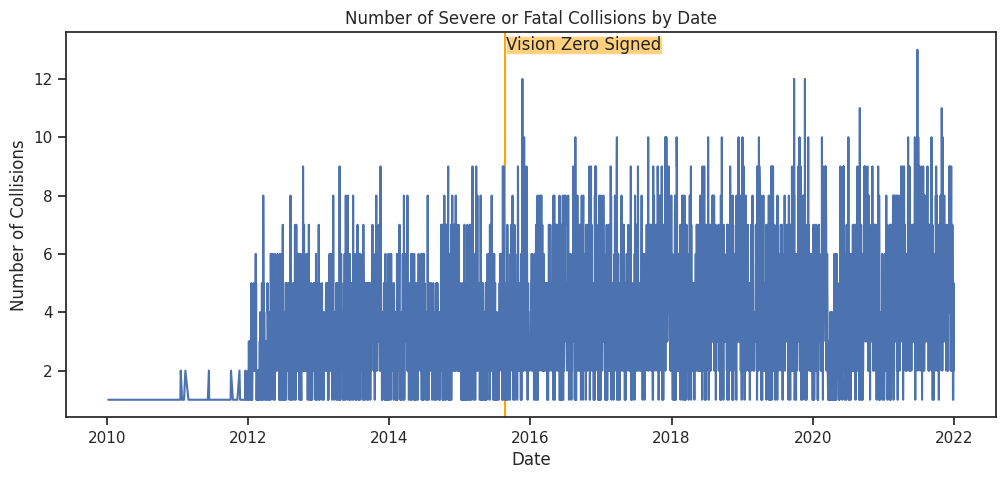

In [87]:
sev_fat = injuries[injuries["mo_code_clean"].isin(["3024","3027"])] ### duplicated dr_numbers
sev_fat.loc[:,'date_occurred_dt'] = sev_fat['dttm_occurred'].dt.date
sev_fat.loc[:,"pre_post_vision_zero"] = sev_fat["dttm_occurred"].dt.date-datetime.date(2015,8,24)

sev_fat_collisions = pd.DataFrame(sev_fat.groupby(['date_occurred_dt']).dr_number.nunique()).rename(columns={"dr_number":"NumCollisions"}).sort_index()

sev_fat_col_fig = plt.figure(figsize=(12,5))

plt.axvline(pd.to_datetime("2015-08-24"), color="orange")
plt.annotate("Vision Zero Signed", (pd.to_datetime("2015-08-30"),13),
             bbox=dict(boxstyle="square", fc="orange", alpha=0.5, pad=0))

plt.plot(sev_fat_collisions)
plt.xlabel("Date")
plt.ylabel("Number of Collisions")
plt.title('Number of Severe or Fatal Collisions by Date')
plt.show()

In [88]:
max(sev_fat_collisions.NumCollisions)

13

We see that the maximum number of fatal or severe collisions per day was 13 collisions. This is a very small number in statistics, epsecially significant testing. I can run the analysis through the functions as before, but the tests may be inconclusive due to the small numbers.

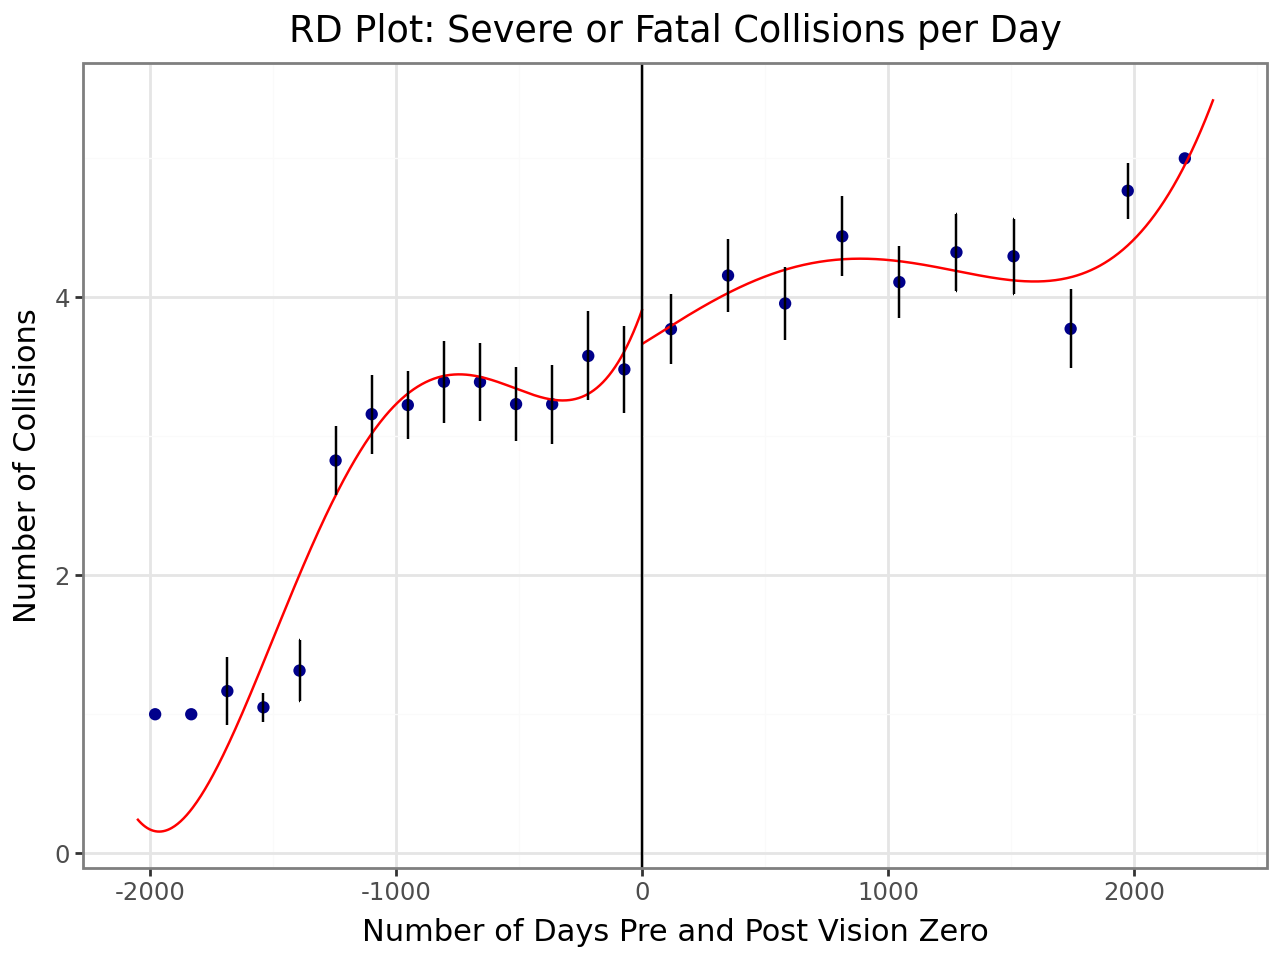

Call: rdrobust
Number of Observations:                  3584
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1315       2269
Number of Unique Obs.           1315       2269
Number of Effective Obs.         400        410
Bandwidth Estimation         421.426    421.426
Bandwidth Bias               757.575    757.575
rho (h/b)                      0.556      0.556

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.063    0.284   -0.223   8.236e-01    [-0.621, 0.494]
Bias-Corrected    -0.174    0.284   -0.611   5.413e-01    [-0.731, 0.384]
Robust            -0.174    0

In [89]:
sev_fat_vz = sev_fat.groupby(["pre_post_vision_zero"])["dr_number"].nunique().reset_index(name='Collisions')
sev_fat_vz

# # y = number of collisions
# # x = num of days pre-post Vision Zero

num_collisions_sev_fat = sev_fat_vz["Collisions"]
days_coll_sev_fat = sev_fat_vz.pre_post_vision_zero.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions_sev_fat, x=days_coll_sev_fat, binselect="es", ci=95,
         title="RD Plot: Severe or Fatal Collisions per Day",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Vision Zero")

### rdrobust with all estimates
print(rdrobust(y=num_collisions_sev_fat, x=days_coll_sev_fat, all=True))

In [90]:
print(f'{min(sev_fat_vz.pre_post_vision_zero)}')
print(f'{max(sev_fat_vz.pre_post_vision_zero)}')
print(f'{max(sev_fat_vz.Collisions)}')

-2054 days +00:00:00
2321 days 00:00:00
13


We see that in general, the number of severe or fatal collisions per day increased despite an initial drop after Vision Zero was signed. The increase is not statistically significant. In general, there are 3 or 4 fatal/severe collisions in a day.

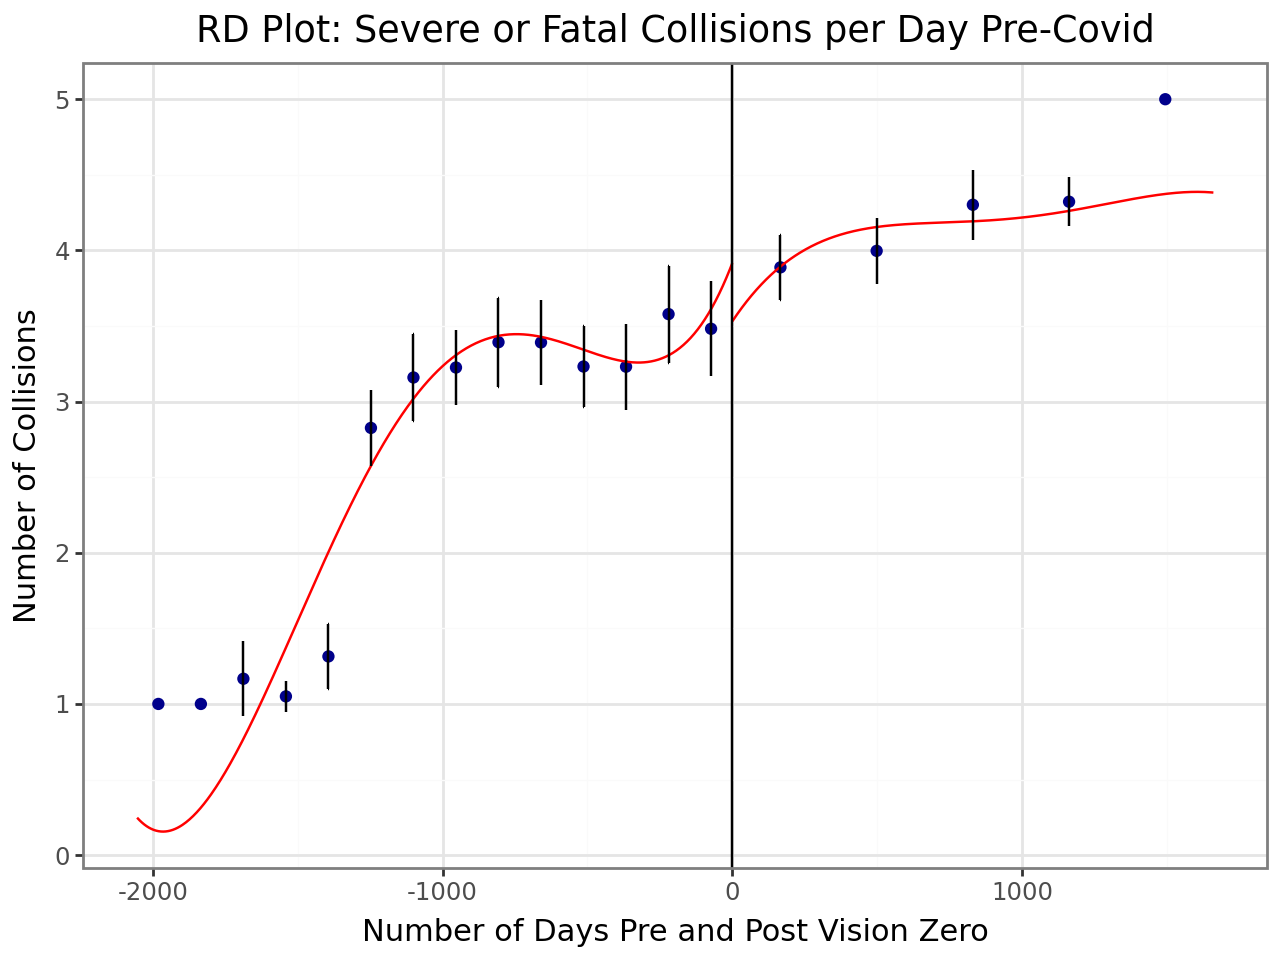

Call: rdrobust
Number of Observations:                  2944
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1315       1629
Number of Unique Obs.           1315       1629
Number of Effective Obs.         391        401
Bandwidth Estimation          412.21     412.21
Bandwidth Bias               707.135    707.135
rho (h/b)                      0.583      0.583

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.061    0.288   -0.212   8.320e-01    [-0.624, 0.502]
Bias-Corrected    -0.162    0.288   -0.564   5.729e-01    [-0.726, 0.401]
Robust            -0.162    0

In [91]:
sev_fat_precovid = sev_fat[sev_fat["date_occurred_dt"]<datetime.date(2020,3,11)]

sev_fat_vz_precovid = sev_fat_precovid.groupby(["pre_post_vision_zero"])["dr_number"].nunique().reset_index(name='Collisions')
sev_fat_vz_precovid

# # y = number of collisions
# # x = num of days pre-post Vision Zero

num_collisions_sev_fat_precovid = sev_fat_vz_precovid["Collisions"]
days_coll_sev_fat_precovid = sev_fat_vz_precovid.pre_post_vision_zero.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions_sev_fat_precovid, x=days_coll_sev_fat_precovid, binselect="es", ci=95,
         title="RD Plot: Severe or Fatal Collisions per Day Pre-Covid",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Vision Zero")

### rdrobust with all estimates
print(rdrobust(y=num_collisions_sev_fat_precovid, x=days_coll_sev_fat_precovid, all=True))

Even when we discount the days after the pandemic was occurred, we still see an increase in the number of severe or fatal collisions, but again, these were not statistically significant.

<ipython-input-92-c5a8d556c7bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


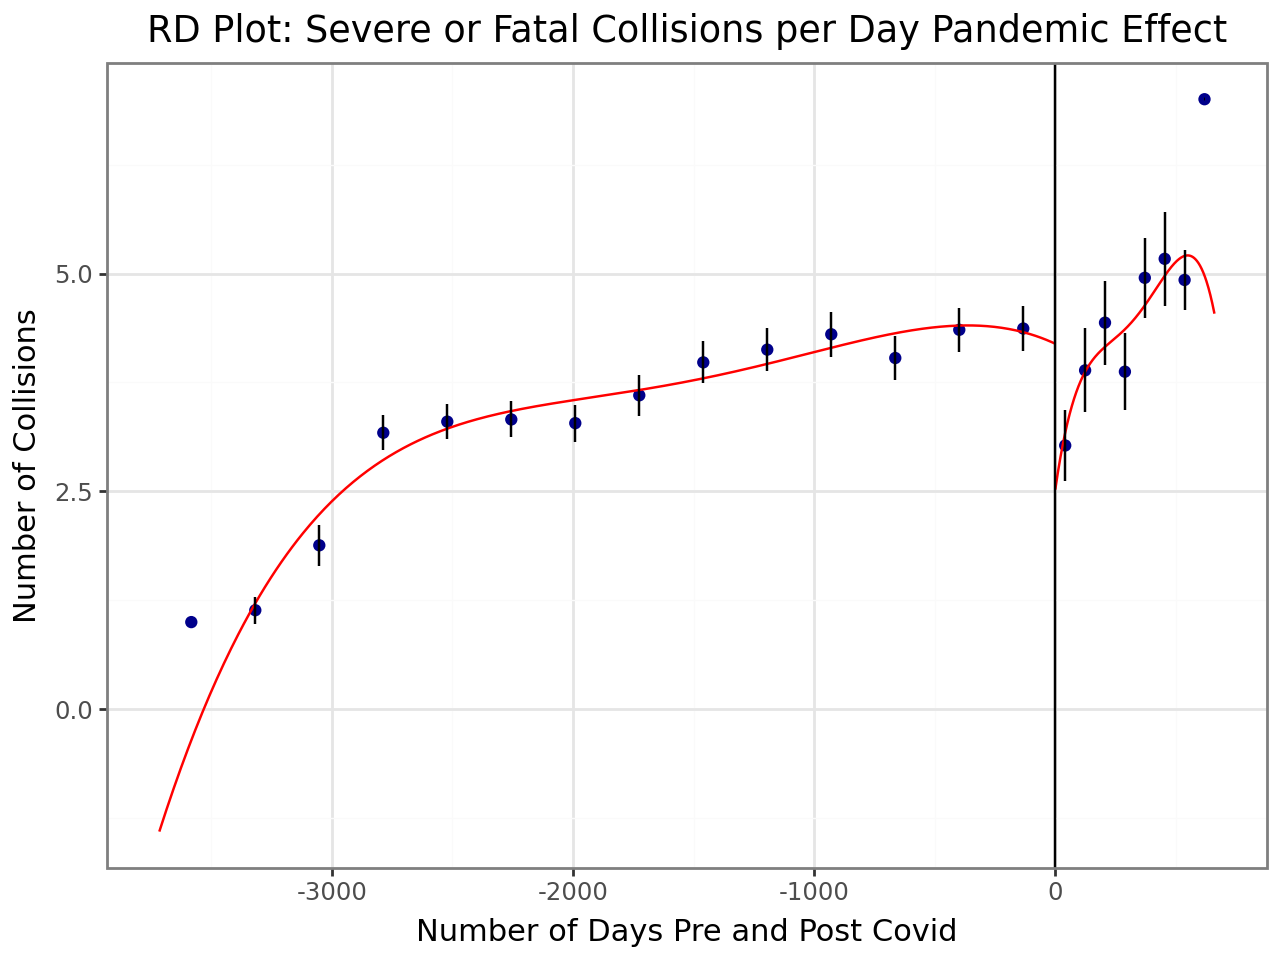

Call: rdrobust
Number of Observations:                  3584
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          2944        640
Number of Unique Obs.           2944        640
Number of Effective Obs.         160        153
Bandwidth Estimation         161.531    161.531
Bandwidth Bias               277.168    277.168
rho (h/b)                      0.583      0.583

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -2.087    0.474   -4.406   1.053e-05   [-3.016, -1.159]
Bias-Corrected     -2.24    0.474   -4.729   2.261e-06   [-3.169, -1.312]
Robust             -2.24    0

In [92]:
sev_fat.loc[:,"postcovid"] = sev_fat["dttm_occurred"].dt.date-datetime.date(2020,3,11)

sev_fat_cov = sev_fat.groupby(["postcovid"])["dr_number"].nunique().reset_index(name='Collisions')
sev_fat_cov

# # y = number of collisions
# # x = num of days pre-post Vision Zero

num_collisions_sev_fat_cov = sev_fat_cov["Collisions"]
days_coll_sev_fat_cov = sev_fat_cov.postcovid.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions_sev_fat_cov, x=days_coll_sev_fat_cov, binselect="es", ci=95,
         title="RD Plot: Severe or Fatal Collisions per Day Pandemic Effect",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Covid")

### rdrobust with all estimates
print(rdrobust(y=num_collisions_sev_fat_cov, x=days_coll_sev_fat_cov, all=True))

Interestingly enough, the number of Severe or Fatal collisions had an immediate decrease after the pandemic was declared, but it quickly climbed up. There is a statistically significant difference via this regression discontinuity analysis, so the number of severe or fatal collisions does differ, and it looks like it continues to increase; however, when we view the y-axis and notice the scale, the dots are generally between 2.5 and 5, meaning that even when the slope is different, the number of collisions is still around 3-5 fatal/severe collisions a day.

In [93]:
severe_fat_dr_numbers = sev_fat.dr_number.unique()
severe_fat_dr_numbers = pd.DataFrame(severe_fat_dr_numbers, columns=["dr_number"])

df_severe_fatal = dfin.merge(severe_fat_dr_numbers, on='dr_number', how='inner')

lat_sev_fat = df_severe_fatal["latitude"][np.logical_not(np.isnan(df_severe_fatal["latitude"]))]
lon_sev_fat = df_severe_fatal["longitude"][np.logical_not(np.isnan(df_severe_fatal["longitude"]))]

map_severe_fatal = folium.Map(location=[df_severe_fatal["latitude"].mean(),df_severe_fatal["longitude"].mean()],
                 zoom_start=10,
                 control_scale=True)
HeatMap(list(zip(lat_sev_fat, lon_sev_fat))).add_to(map_severe_fatal)

map_severe_fatal

This is where the collisions where there was a severe or fatal injuries occur. It appears to be spread all over LA.

# Conclusion

In [94]:
number_collisions_nocovid["Collisions"].describe()

,Collisions
count,3721.000000
mean,139.378662
std,23.652283
min,68.000000
25%,122.000000
50%,138.000000
75%,156.000000
max,230.000000


In [95]:
sev_fat_vz_precovid["Collisions"].describe()

,Collisions
count,2944.000000
mean,3.723166
std,1.979454
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,12.000000


In [96]:
3.72/139.38

0.026689625484287563

In [97]:
3.72*365

1357.8000000000002

While LA has a lot of collisions in general, the number of severe or fatal injuries from collisions, in comparison, is "rare." There are about 139 collisions a day (prior to Covid) and of them, only 4 of them are severe/fatal collisions on average. This means that only about 2% of a LA collisions in a day would  contain severe or fatal injuries. However, this number can add up. Under the assumption that there's only one person with severe or fatal injuries when the relevant MO codes appear on the collision report, that means there will be at least 1,358 people affected per year, and this number is projected to increase as shown by the analysis of this data.

Not only that, but the number of collisions have only increased by the year  and the proportion of severe and fatal injuries have not changed much. There is actually a statistically significant increase in the overall number of collisions and victims post-Vision Zero enactment.

If we look at the same data, there is a drop in the number of collisions and victims when Covid-19 was declared a pandemic by the WHO. There was already the start of a trend for the decrease prior to the pandemic declaration, and this may be explained by people hearing news of the pandemic, and starting to decrease their outdoor activities. Once the pandemic was officially declared, there was a sharp decline in the number of collisions. When we take a look at the number of severe or fatal injuries, there were still about 3-5 collisions. Even if Covid-19 lowered the total amount of collisions, the number of severe or fatal injuries remained about the same.

This implies that Vision Zero isn't effective at decreasing the number of collisions or the number of severe or fatal wounds. Removing the number of cars on the streets may be effective at decreasing the number of collisions overall, but not the number of severe or fatal injuries from collisions. And if the trends continue, then there will be more and more collisions in the coming years.

# Addendum

Re-writing `dfin` and `mo_fin` because columns were added. Saved with an ending so that there will be no confusion when subsequent notebooks is/are run.

In [98]:
dfin.to_pickle('LA_Traffic_Collisions_dfin_2.pkl')

In [99]:
mo_fin.to_pickle('LA_Traffic_Collisions_mo_fin_2.pkl')